In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from scipy.stats import linregress
from shapely.geometry import Polygon
from scipy.special import erf

### Define functions

In [117]:
g = 9.81 # m/s2, gravity
beta = 1e-4 # degC-1, thermal coefficient expansion water
deltaT = 20.5 # degC, melting-ambient
alpha = 0.133e-6 # m2/s, thermal diffiusivity water
#alpha = 1.02e-6 # m2/s, thermal diffiusivity ice
nu = 1.4e-6 # m2/s, kinematic viscosity water
Pr = 10 # variable
kappa = 580e-3 # W/Km, thermal conductivity water
T_in = 16 # degC, initial negative temperature ice
rho_ice = 917 # kg/m3, density ice
L_f = 334e3 # J/kg, latent heat fusion water
c_s = 4186 # J/kgK, specific heat water 

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.
    https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def correct_outliers(y,precision=0.1):
    """Corrects outliers by interpolating between them. Outliers are defined where there is a change of more than a certain fraction in the normalised gradient. 
    This function can only handle one outlier.

    Args:
        y (np.array): input array
        precision (float) : between 0 and 1, max allowed change in the gradient

    Returns:
        np.array: array without outliers.
    """    
    outliers = np.where(abs(np.gradient(y/y[0]))>precision)[0]
    if len(outliers)>1:
        # only works if there is one outlier
        y[np.mean(outliers,dtype=int)] = np.nan
        y = np.array(y)
        nans,x = nan_helper(y)
        y[nans] = np.interp(x(nans),x(~nans),y[~nans])
    return y

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def rotate(points, origin, degrees):
    """Rotates a polygon (list of x,y-coordinates) about an origin of an angle in degrees

    Args:
        points (np.array/list): points coordinates
        origin (np.array/list): coordinate center of rotation
        degrees (float): degrees of rotation

    Returns:
        np.array: coordinates of rotated points
    """    
    radians = np.deg2rad(degrees)
    x,y = points[:,0],points[:,1]
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = np.cos(radians)
    sin_rad = np.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return np.vstack((qx, qy)).T

def PolyArea(x,y):
    """Returns area of a polygon given the x,y-coordinates of its points

    Args:
        x (np.array): x-coordinates
        y (np.array): y-coordinates

    Returns:
        _type_: _description_
    """    
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def Kell_rho(T):
    """Returns density of PURE water at temperature T according to the Kell function (5th order polynomial fit)

    Args:
        T (float): temperature [degC]

    Returns:
        float: density of water [kg/m3]
    """    
    a = -2.8054253e-10
    b = 1.0556302e-7
    c = -4.6170461e-5
    d = -0.0079870401
    e = 16.945176
    f = 999.83952
    g = 0.01687985
    rho = (((((a*T+b)*T+c)*T+d)*T+e)*T+f) / (1+g*T)
    return rho

def MH_rho(T,S=0):
    """Returns density of salty water at temperature T, with salinity S according to the formula in Millero, Huang,2009. 
    That formula is calculates the additional density due to the salts. The pure water density is calculated from the Kell formula. 

    Args:
        T (float): temperature [degC]
        S (float): water salinity [g/l], Defaults to 0 g/l.

    Returns:
        float: density of water [kg/m3]
    """   
    a0,a1,a2,a3,a4,a5 = 8.211458E-01,-3.959680E-03,7.305182E-05,-8.282446E-07,5.386657E-09,0
    A = a0 + a1*T + a2*T**2 + a3*T**3 + a4*T**4 + a5*T**5
    b0,b1,b2 = -6.058307E-03,8.265457E-05,-1.077747E-06
    B = b0 + b1*T + b2*T**2
    C = 5.265280E-04
    rho = A*S + B*S**1.5 + C*S**2 + Kell_rho(T)
    return rho

def Nu_latent(R,T_water, dt):
    """Returns an approximated value of the Nusselt number that takes the latent heat as the only heat that is transferred.
    For consistency with Ra(r,T1,T2,S) the parameter passed is the radius of the cylinder, and the length scale is the diameter. 

    Args:
        L (float): radius of cylinder
        dt (float): time interval [s]

    Returns:
        float: value of Nusselt number
    """   
    h = -(np.gradient(radii)/dt)*rho_ice*L_f/T_water
    return (2*R)*h/kappa 

def Nu_areas(A,T_water, dt):
    """Returns an approximated value of the Nusselt number that accounts for the latent and sensitive heat.
    The parameter passed is the area of the cylinder. 

    Args:
        A (float): area of cylinder [m2]
        T_water (float): bulk water temperature [degC]
        dt (float): time interval [s]

    Returns:
        float: value of Nusselt number
    """   
    h = -(np.gradient(A)/dt)*rho_ice*(L_f+c_s*T_in)/(np.pi*T_water)
    return h/kappa

def Ra(r,T1,T2):
    """Calculates Rayleigh number for a cylinder in water, given radius and two temperatures. The density is calculated according to the Kell's formula.

    Args:
        r (float): cylinder's radius [m]
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    Tavg = np.mean([T1,T2])
    rho = Kell_rho(Tavg)
    deltaRho = abs(Kell_rho(T1)-Kell_rho(T2))
    return g*deltaRho*(2*r)**3/(alpha*nu*rho)

def Ra_salinity(r,T1,T2,S=0):
    """Calculates Rayleigh number for a cylinder in (possibly salty) water, given radius,salinity, and two temperatures. 
    The density is calculated according to Millero and Huang, 2009.

    Args:
        r (float): cylinder's radius [m]
        S (float,optional): water salinity [g/l], Defaults to 0 g/l.
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    T_min = min(T1,T2)
    T_max = max(T1,T2)
    rho1 = MH_rho(T_min,S=0) # fresh, cold water
    rho2 = MH_rho(T_max,S=S)
    rho_avg = np.mean((rho1,rho2))

    deltaRho = abs(rho1-rho2)
    return g*deltaRho*(2*r)**3/(alpha*nu*rho_avg)

def Nu(Ray):
    """Calculates Nusselt number for a cylinder in water given Rayleigh number and Prandtl number (not function variable). Formula from Churchill and Chu, 1975

    Args:
        Ray (float): Rayleigh number

    Returns:
        float: Nusselt number
    """    
    return (0.6 + (0.387*Ray**(1/6)) / ( ( 1 + (0.559/Pr)**(9/16) ) ** (16/9) ) )**2 

def h(Nu,r):   
    return kappa*Nu/(2*r)

def drdt(h,r,t):
    T_0 = -T_in
    T_star = T_0 + (deltaT-T_0)*.5*erf(r/np.sqrt(alpha*t))
    dT_stardt = (deltaT-T_0)*.5 * np.exp(-r**2/(alpha*t)) / np.sqrt(alpha*t)
    return -(h*deltaT+kappa*dT_stardt)/(rho_ice*(L_f+c_s*(-T_star)))

def evolution(r_0):
    timesteps = 1600 #s
    radii = [r_0,]
    r = r_0
    for timestep in range(1,timesteps):
        # timestep is in seconds
        Ra_ = Ra(r,-16,20)
        Nu_ = Nu(Ra_)
        h_ = h(Nu_,r)
        drdt_ = drdt(h_,r,timestep)
        # print(Ra_,Nu_,h_,drdt_)
        r = r + drdt_
        radii.append(r)
    return radii

def makePolygonBelow(polygon, level):
    """Draws the part of a polygon which is below a horizontal level. Returns a list of coordinates. 

    Args:
        polygon (np.array): polygon coordinates
        level (float): horizontal level 

    Returns:
        np.array: coordinates of polygon below level
    """    
    newY = np.where(polygon[:,1]<level,polygon[:,1],level)
    polygonBELOW = polygon.copy()
    polygonBELOW[:,1] = newY
    return polygonBELOW



def findWL(polygon, densityRatio=.917, epsilon = 0.001):
    """Finds the water level for an ice polygon immersed in water, with prescribed precision. 

    Args:
        polygon (np.array): polygon coordinates
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.
        epsilon (float, optional): precisio of calculation. Defaults to 0.001.

    Returns:
        float: water level of the immersed polygon
    """    
    originalArea = PolyArea(polygon[:,0],polygon[:,1])
    ymin, ymax = min(polygon[:,1]),max(polygon[:,1])
    mmin, mmax = ymin,ymax
    attempt = ymin + (ymax-ymin) * densityRatio 
    pgbelow = makePolygonBelow(polygon,attempt)
    # plt.plot(pgbelow[:,0],pgbelow[:,1],label='initial attempt')

    newArea = PolyArea(pgbelow[:,0],pgbelow[:,1])

    ratio = newArea/originalArea

    while abs(ratio-densityRatio) > epsilon:
        if ratio-densityRatio > 0:
            mmax = attempt
        else:
            mmin = attempt
        attempt = (mmin+mmax)/2
        pgbelow_ = makePolygonBelow(polygon,attempt)
        newArea_ = PolyArea(pgbelow_[:,0],pgbelow_[:,1])
        ratio = newArea_/originalArea
        # print(f'{newArea_:.2f}',ratio)

    return attempt

def hydrostasy(contour,densityRatio=.917):
    """Returns center of mass and center of buoyancy for an immersed polygon.

    Args:
        contour (np.array): coordinates of polygon.
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.

    Returns:
        tuple: (center of mass, center of buoyancy)
    """    
    polygon = Polygon(contour)
    com = polygon.centroid
    del polygon
    immersedPG = makePolygonBelow(contour,findWL(contour,densityRatio=densityRatio))
    polygon = Polygon(immersedPG)
    cob = polygon.centroid
    return com,cob

# Load one contour

1206931.0274004936 px2


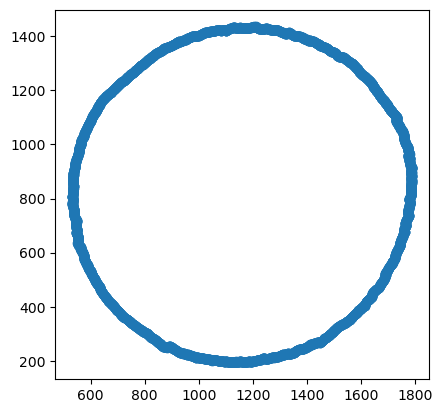

In [6]:
oo = np.genfromtxt('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-12/1st/contours/01.csv',dtype='float',delimiter=',')
oo.shape
plt.figure()
plt.scatter(oo[:,1],oo[:,0])
plt.gca().set_aspect('equal')



print(PolyArea(oo[:,1],oo[:,0]),'px2')

# Theoretical expectations

In [71]:
Kell_rho(4)

999.9719941255903

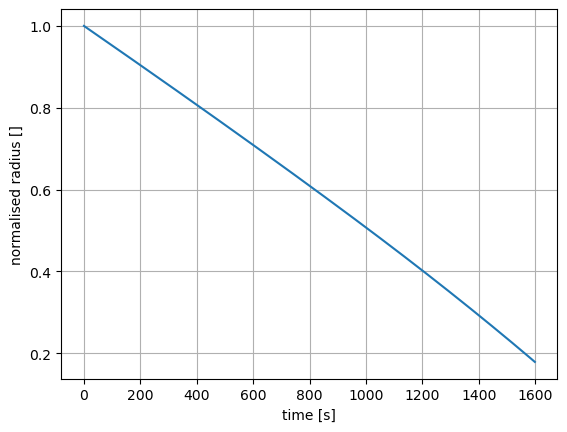

In [72]:
#evolution(0.05)
plt.figure()
plt.plot(np.array(evolution(0.0405))/evolution(0.0405)[0])
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('normalised radius []')

plt.show()

# Radius vs time

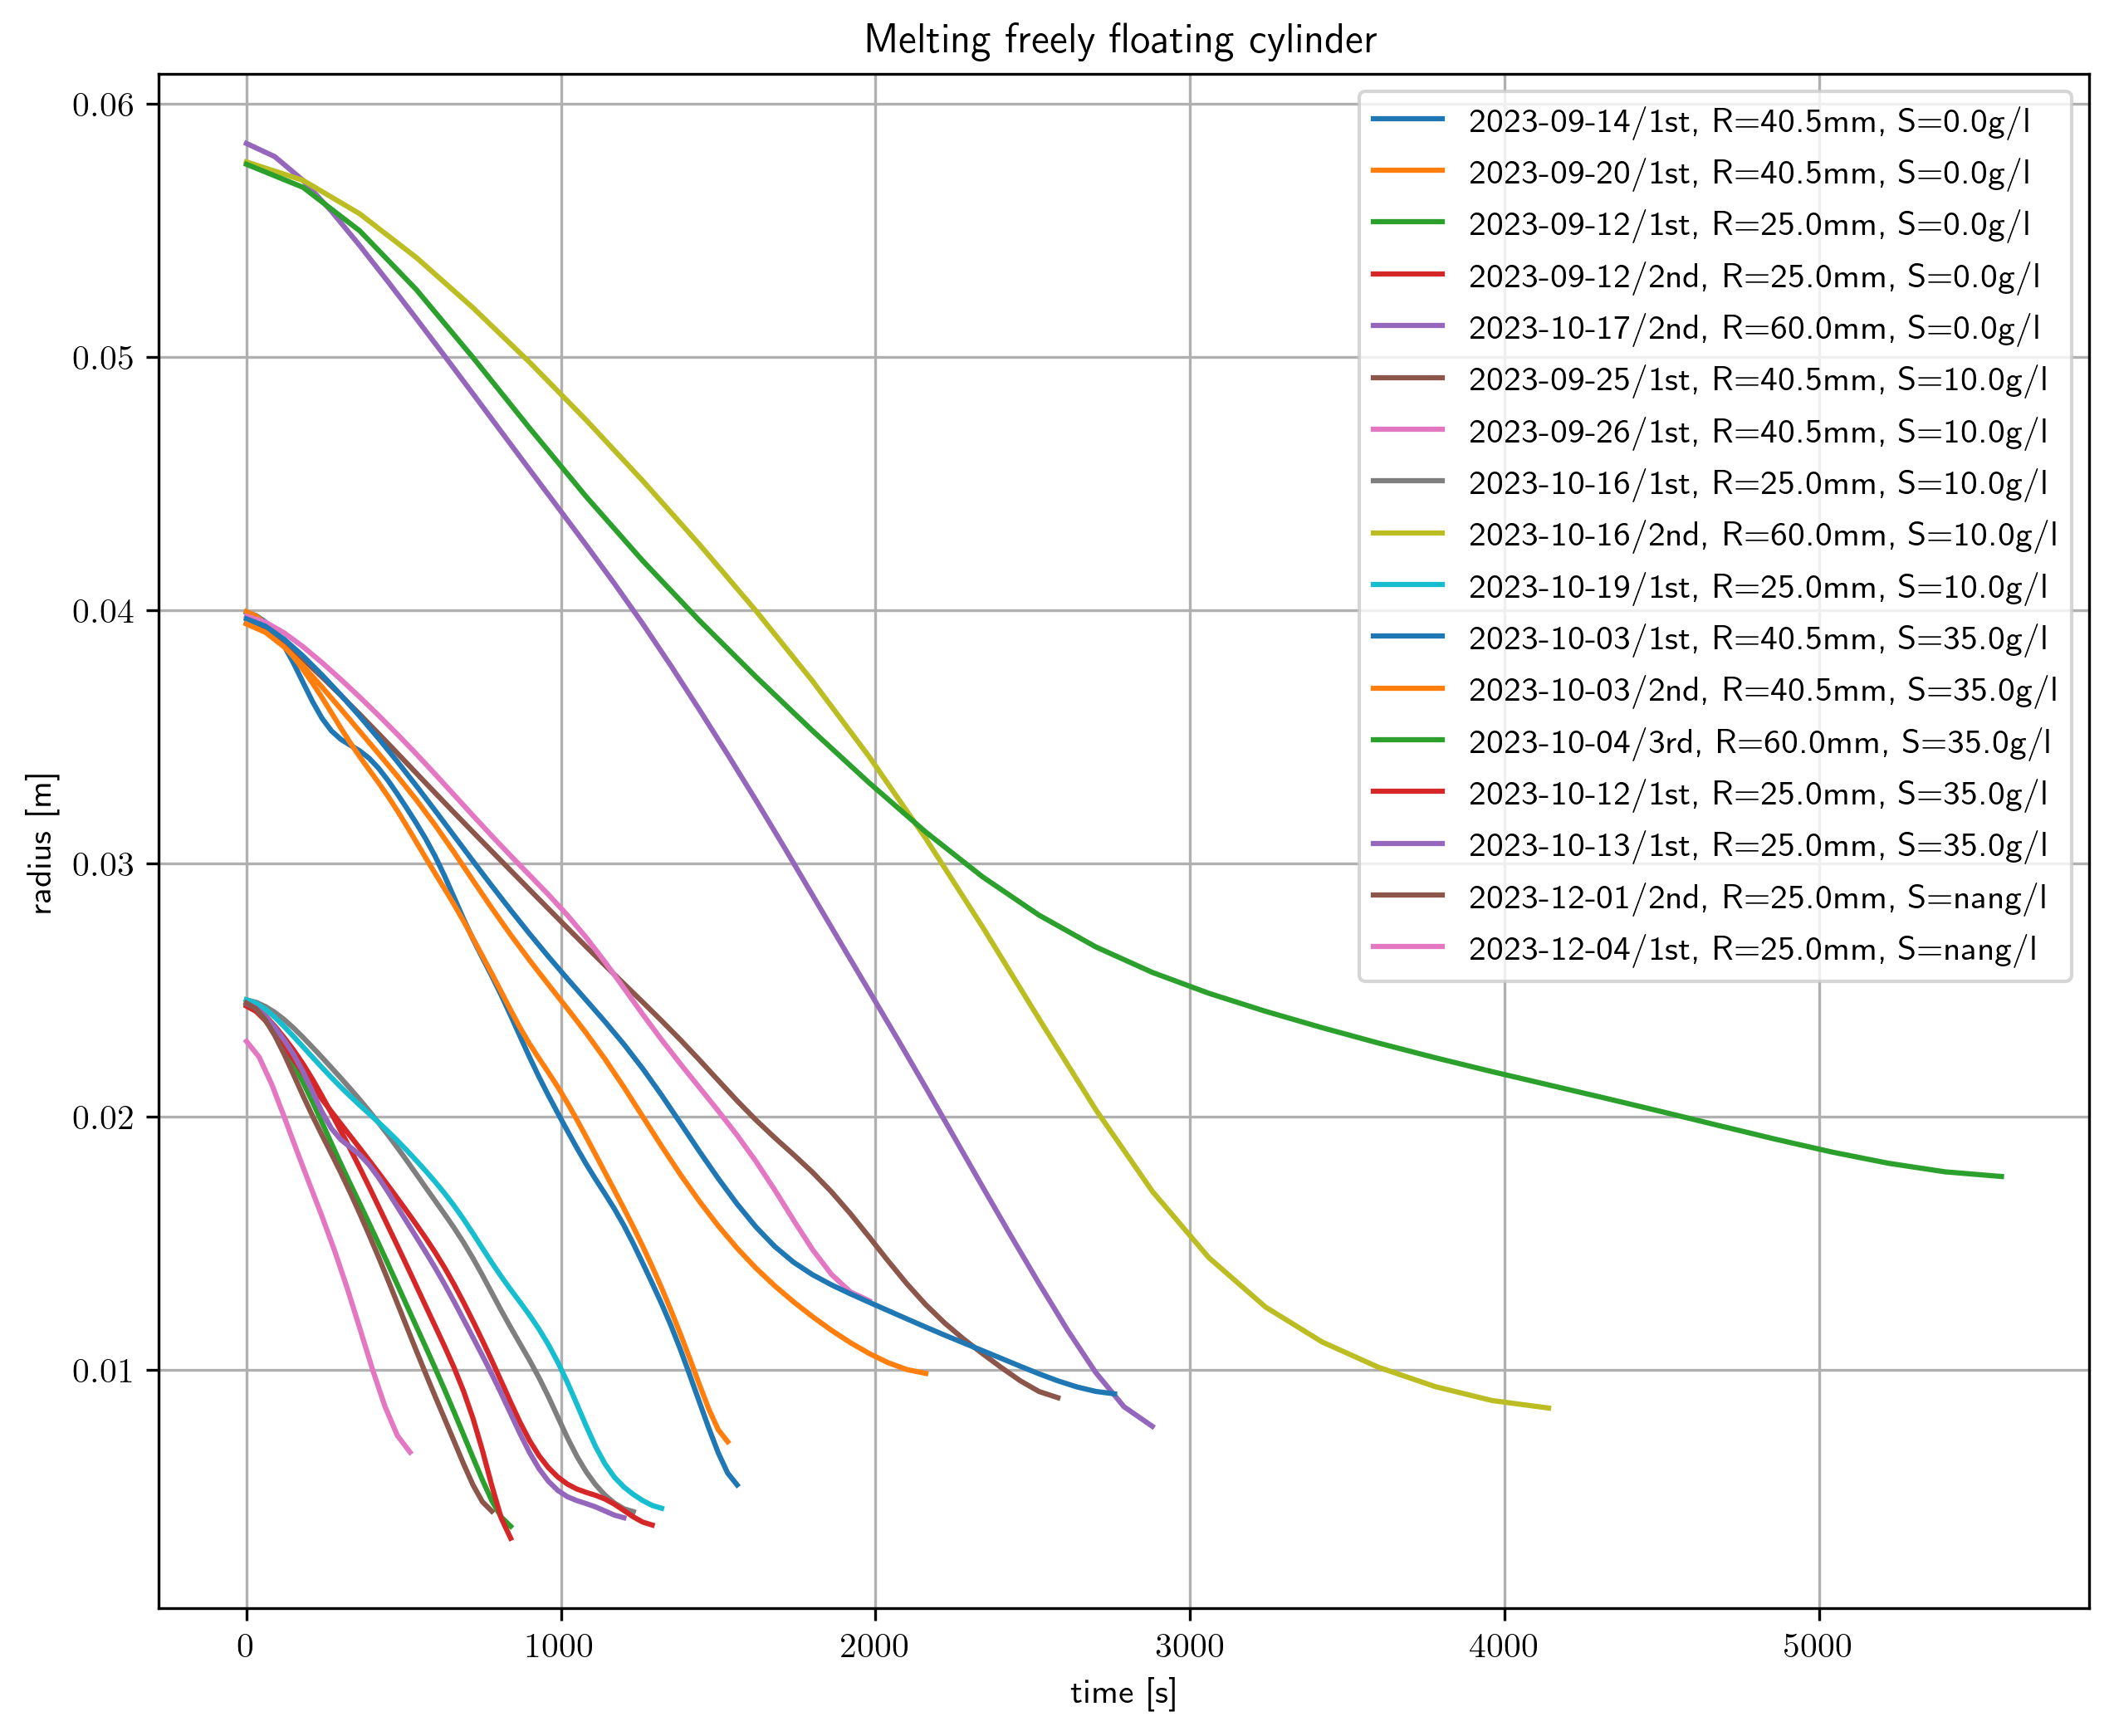

In [143]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,8),dpi=300)
plt.rcParams['text.usetex'] = True

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))

    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    if exp_radius==0.025:
        plt.plot(contours_per_shot*10*np.arange(len(radii)),gf1d(radii,2),
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.0405:
        plt.plot(contours_per_shot*10*np.arange(len(radii)),gf1d(radii,2),
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.06:
        plt.plot(contours_per_shot*30*np.arange(len(radii)),gf1d(radii,2),
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

# plt.plot(np.array(evolution(0.0405))/evolution(0.0405)[0],label='theo')

#slope, _, _,_ = np.linalg.lstsq(30*np.arange(len(radii))[:,np.newaxis],
#                                radii/radii[0])
# plt.plot(30*np.arange(len(radii)),
#         1-slope * 30*np.arange(len(radii)), 
#         label='linear')

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

# Gradient vs time

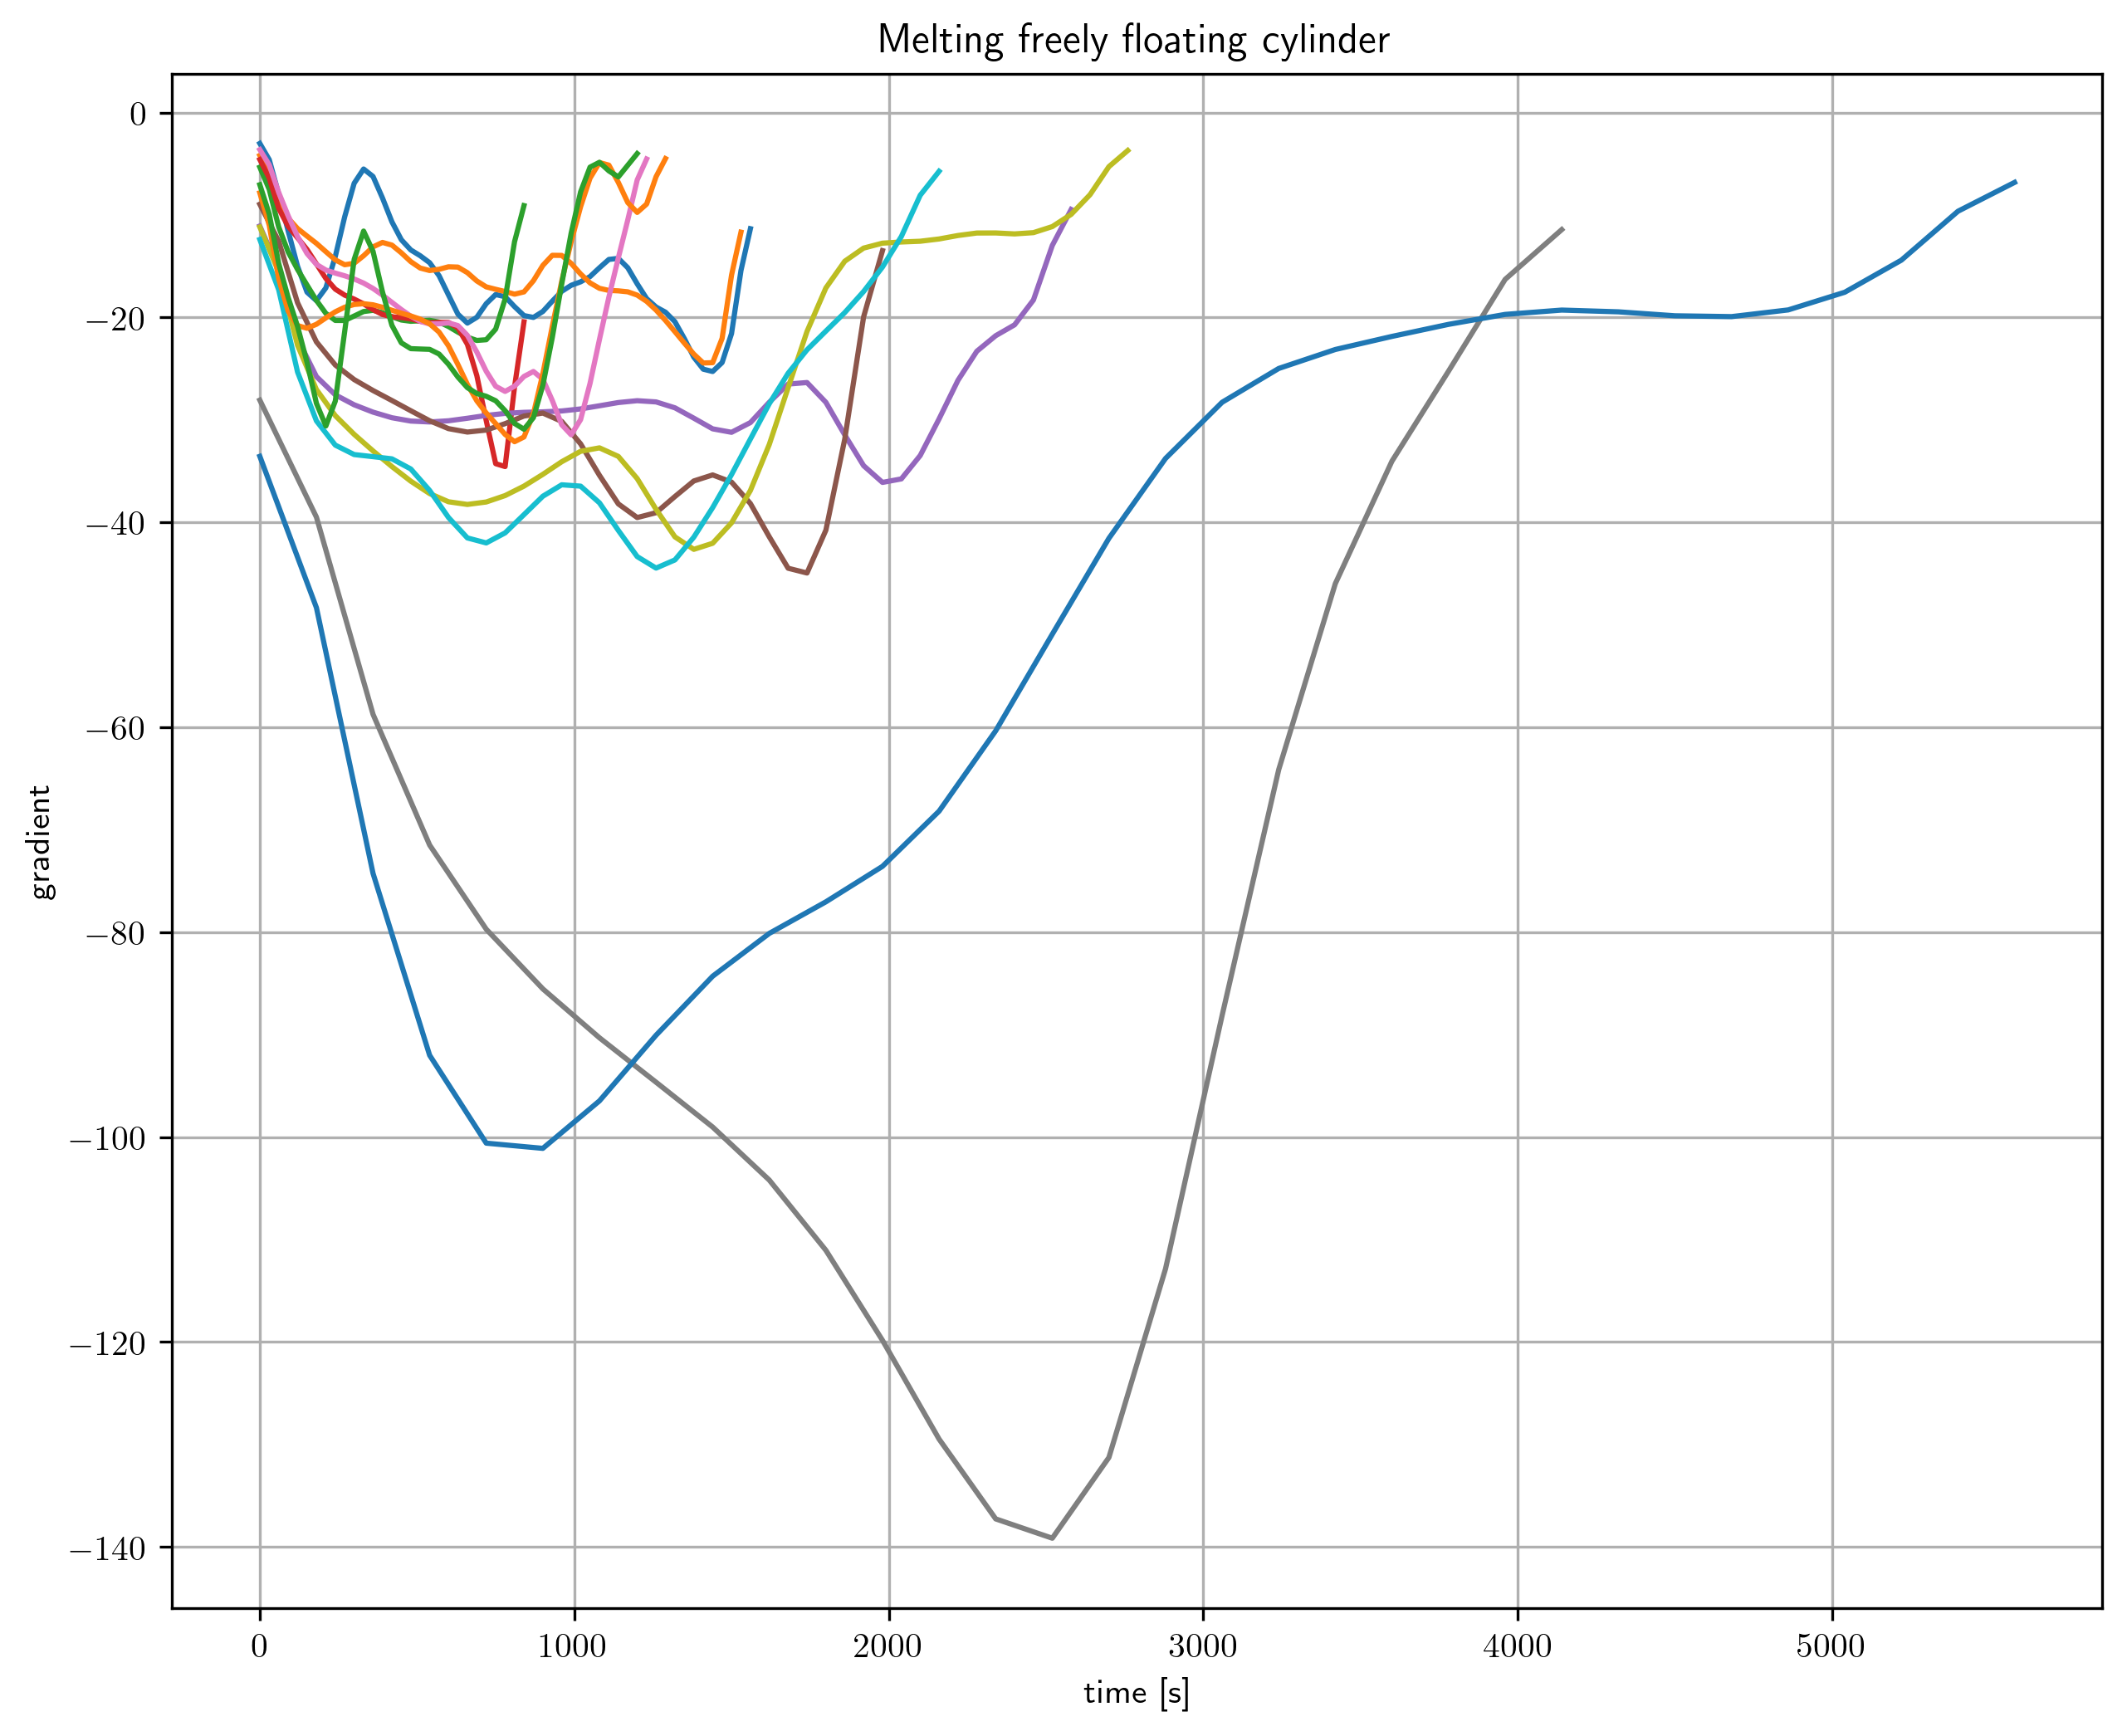

In [145]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', # S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', # S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st']# S=35

plt.figure(figsize=(10,8),dpi=300)
plt.rcParams['text.usetex'] = True

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))

    radii = []
    for contourPATH in contoursPATH:
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
        radii.append(radius)
    
    radii = correct_outliers(radii)

    if exp_radius==0.025:
        plt.plot(contours_per_shot*10*np.arange(len(radii)),np.gradient(gf1d(radii,2)),
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.0405:
        plt.plot(contours_per_shot*10*np.arange(len(radii)),np.gradient(gf1d(radii,2)),
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.06:
        plt.plot(contours_per_shot*30*np.arange(len(radii)),np.gradient(gf1d(radii,2)),
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds


plt.grid()
plt.xlabel('time [s]')
plt.ylabel('gradient')
plt.title('Melting freely floating cylinder')
plt.show()

# Rayleigh vs time

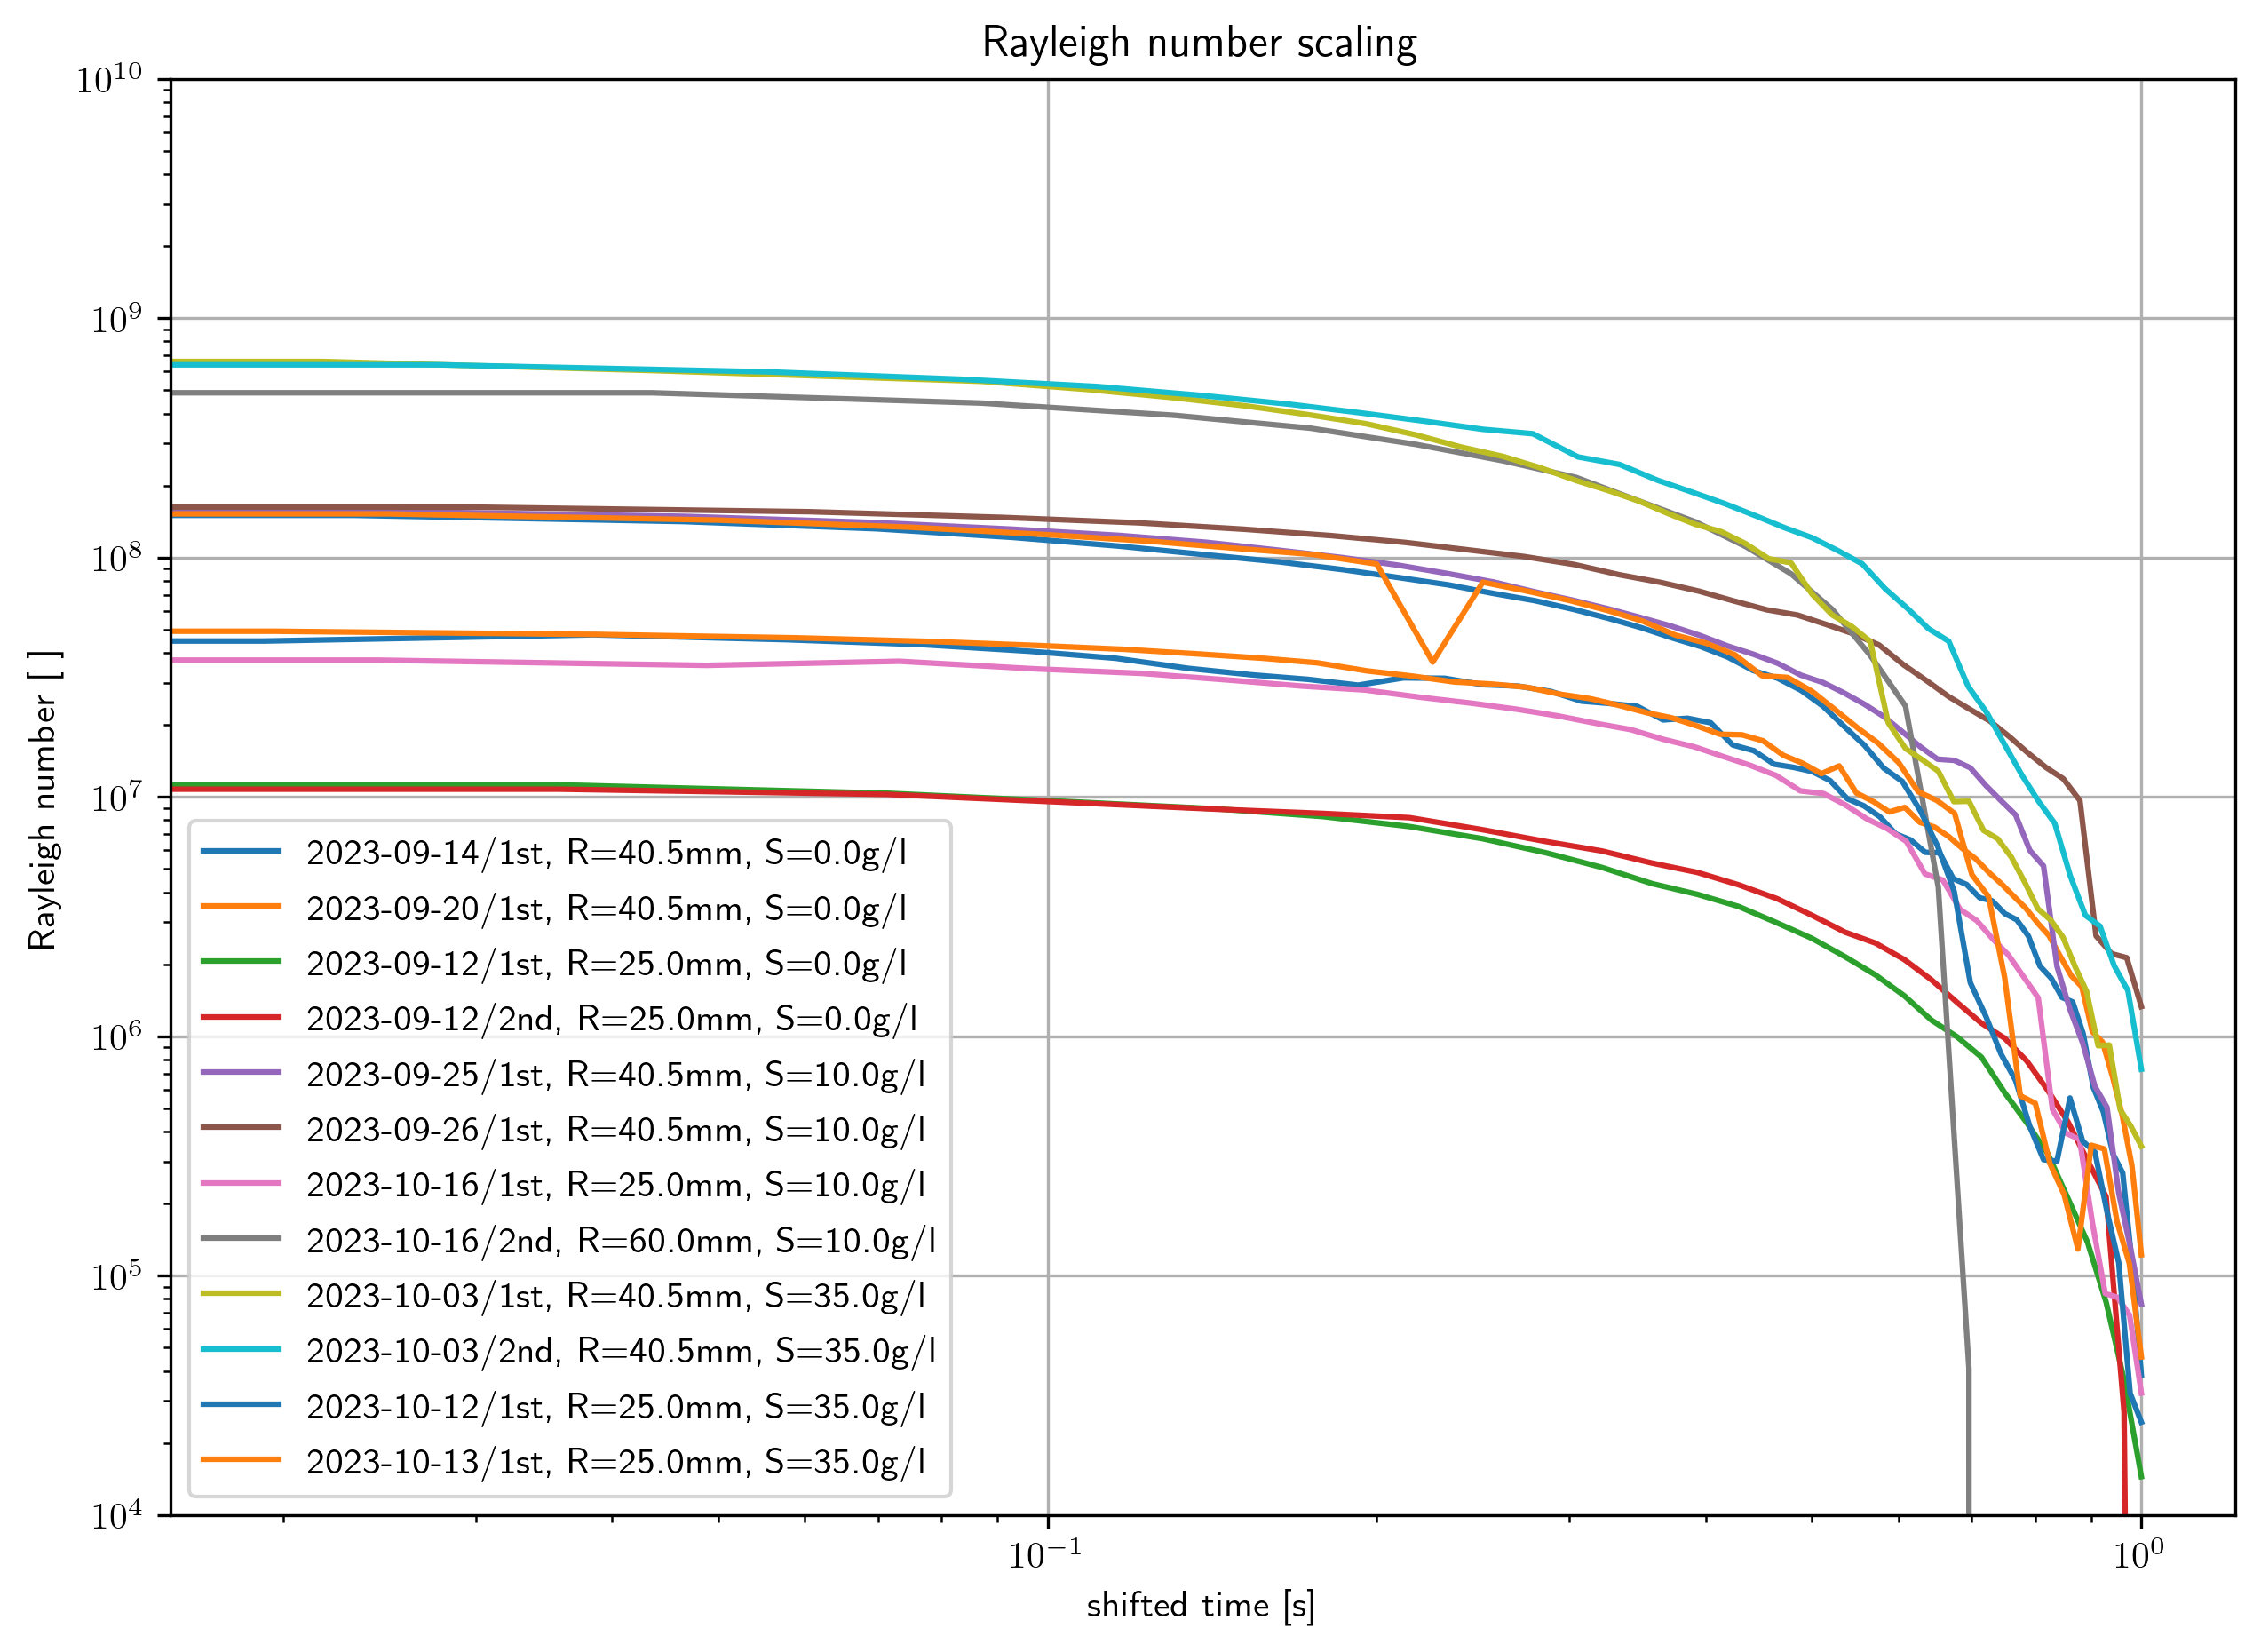

In [453]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', # S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', # S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st']# S=35

plt.figure(figsize=(10,7),dpi=300)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    #if exp_sal==35.: continue

    radii = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            initialArea = np.pi*exp_radius**2 # px
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # px/m2
        # reduce the radius considering only the part that is below the upwelled freshwater (only for salty water)
        if exp_sal==0.:
            # if freshwater, consider all the polygon
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            radii.append(radius)
        else:
            # find waterlevel
            wl = findWL(contour,densityRatio=917/MH_rho(exp_wt,S=exp_sal)) # px
            # find level of molten water
            moltenArea = initialArea - PolyArea(contour[:,1],contour[:,0])/conversion # in m2
            h = moltenArea/.8 # in m
            h = h*np.sqrt(conversion) # in px 
            # calculate polygon under the freshwater level
            contourInSaltyWater = makePolygonBelow(contour,-h+wl)
            # calculate equivalent radius
            radius = np.sqrt(PolyArea(contourInSaltyWater[:,1],contourInSaltyWater[:,0])/np.pi)
            radii.append(radius)
    
    radii = correct_outliers(radii)

    conversion = info[1,1]/radii[0] # m/px
    radii = np.array(radii)
    radii *= conversion

    if exp_radius==0.0405:
        Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
        indexWhereRaX = np.where(Rayleigh_numbers==find_nearest(Rayleigh_numbers,8e6))[0][0] # index where Ra == X
        plt.plot(np.linspace(0,1,len(Rayleigh_numbers)),Rayleigh_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.025:
        Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
        indexWhereRaX = np.where(Rayleigh_numbers==find_nearest(Rayleigh_numbers,8e6))[0][0] # index where Ra == X
        plt.plot(np.linspace(0,1,len(Rayleigh_numbers)),Rayleigh_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.06:
        Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
        if exp_radius==0.06 and exp_sal==35.:continue
        indexWhereRaX = np.where(Rayleigh_numbers==find_nearest(Rayleigh_numbers,8e6))[0][0] # index where Ra == X
        plt.plot(np.linspace(0,1,len(Rayleigh_numbers)),Rayleigh_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds
    
plt.grid()
plt.legend()
plt.xlabel('shifted time [s]')
plt.ylabel('Rayleigh number [ ]')
plt.title('Rayleigh number scaling')

plt.yscale('log')
plt.ylim(1e4,1e10)
plt.xscale('log')

plt.show()

# Nusselt vs time

check area:......4.05e-02 4.05e-02
check area:......4.05e-02 4.05e-02
check area:......2.50e-02 2.50e-02
check area:......2.50e-02 2.50e-02
check area:......6.00e-02 6.00e-02
check area:......4.05e-02 3.87e-02
check area:......4.05e-02 3.87e-02
check area:......2.50e-02 2.39e-02
check area:......6.00e-02 5.73e-02
check area:......2.50e-02 2.39e-02
check area:......4.05e-02 3.83e-02
check area:......4.05e-02 3.83e-02
check area:......6.00e-02 5.68e-02
check area:......2.50e-02 2.36e-02
check area:......2.50e-02 2.37e-02


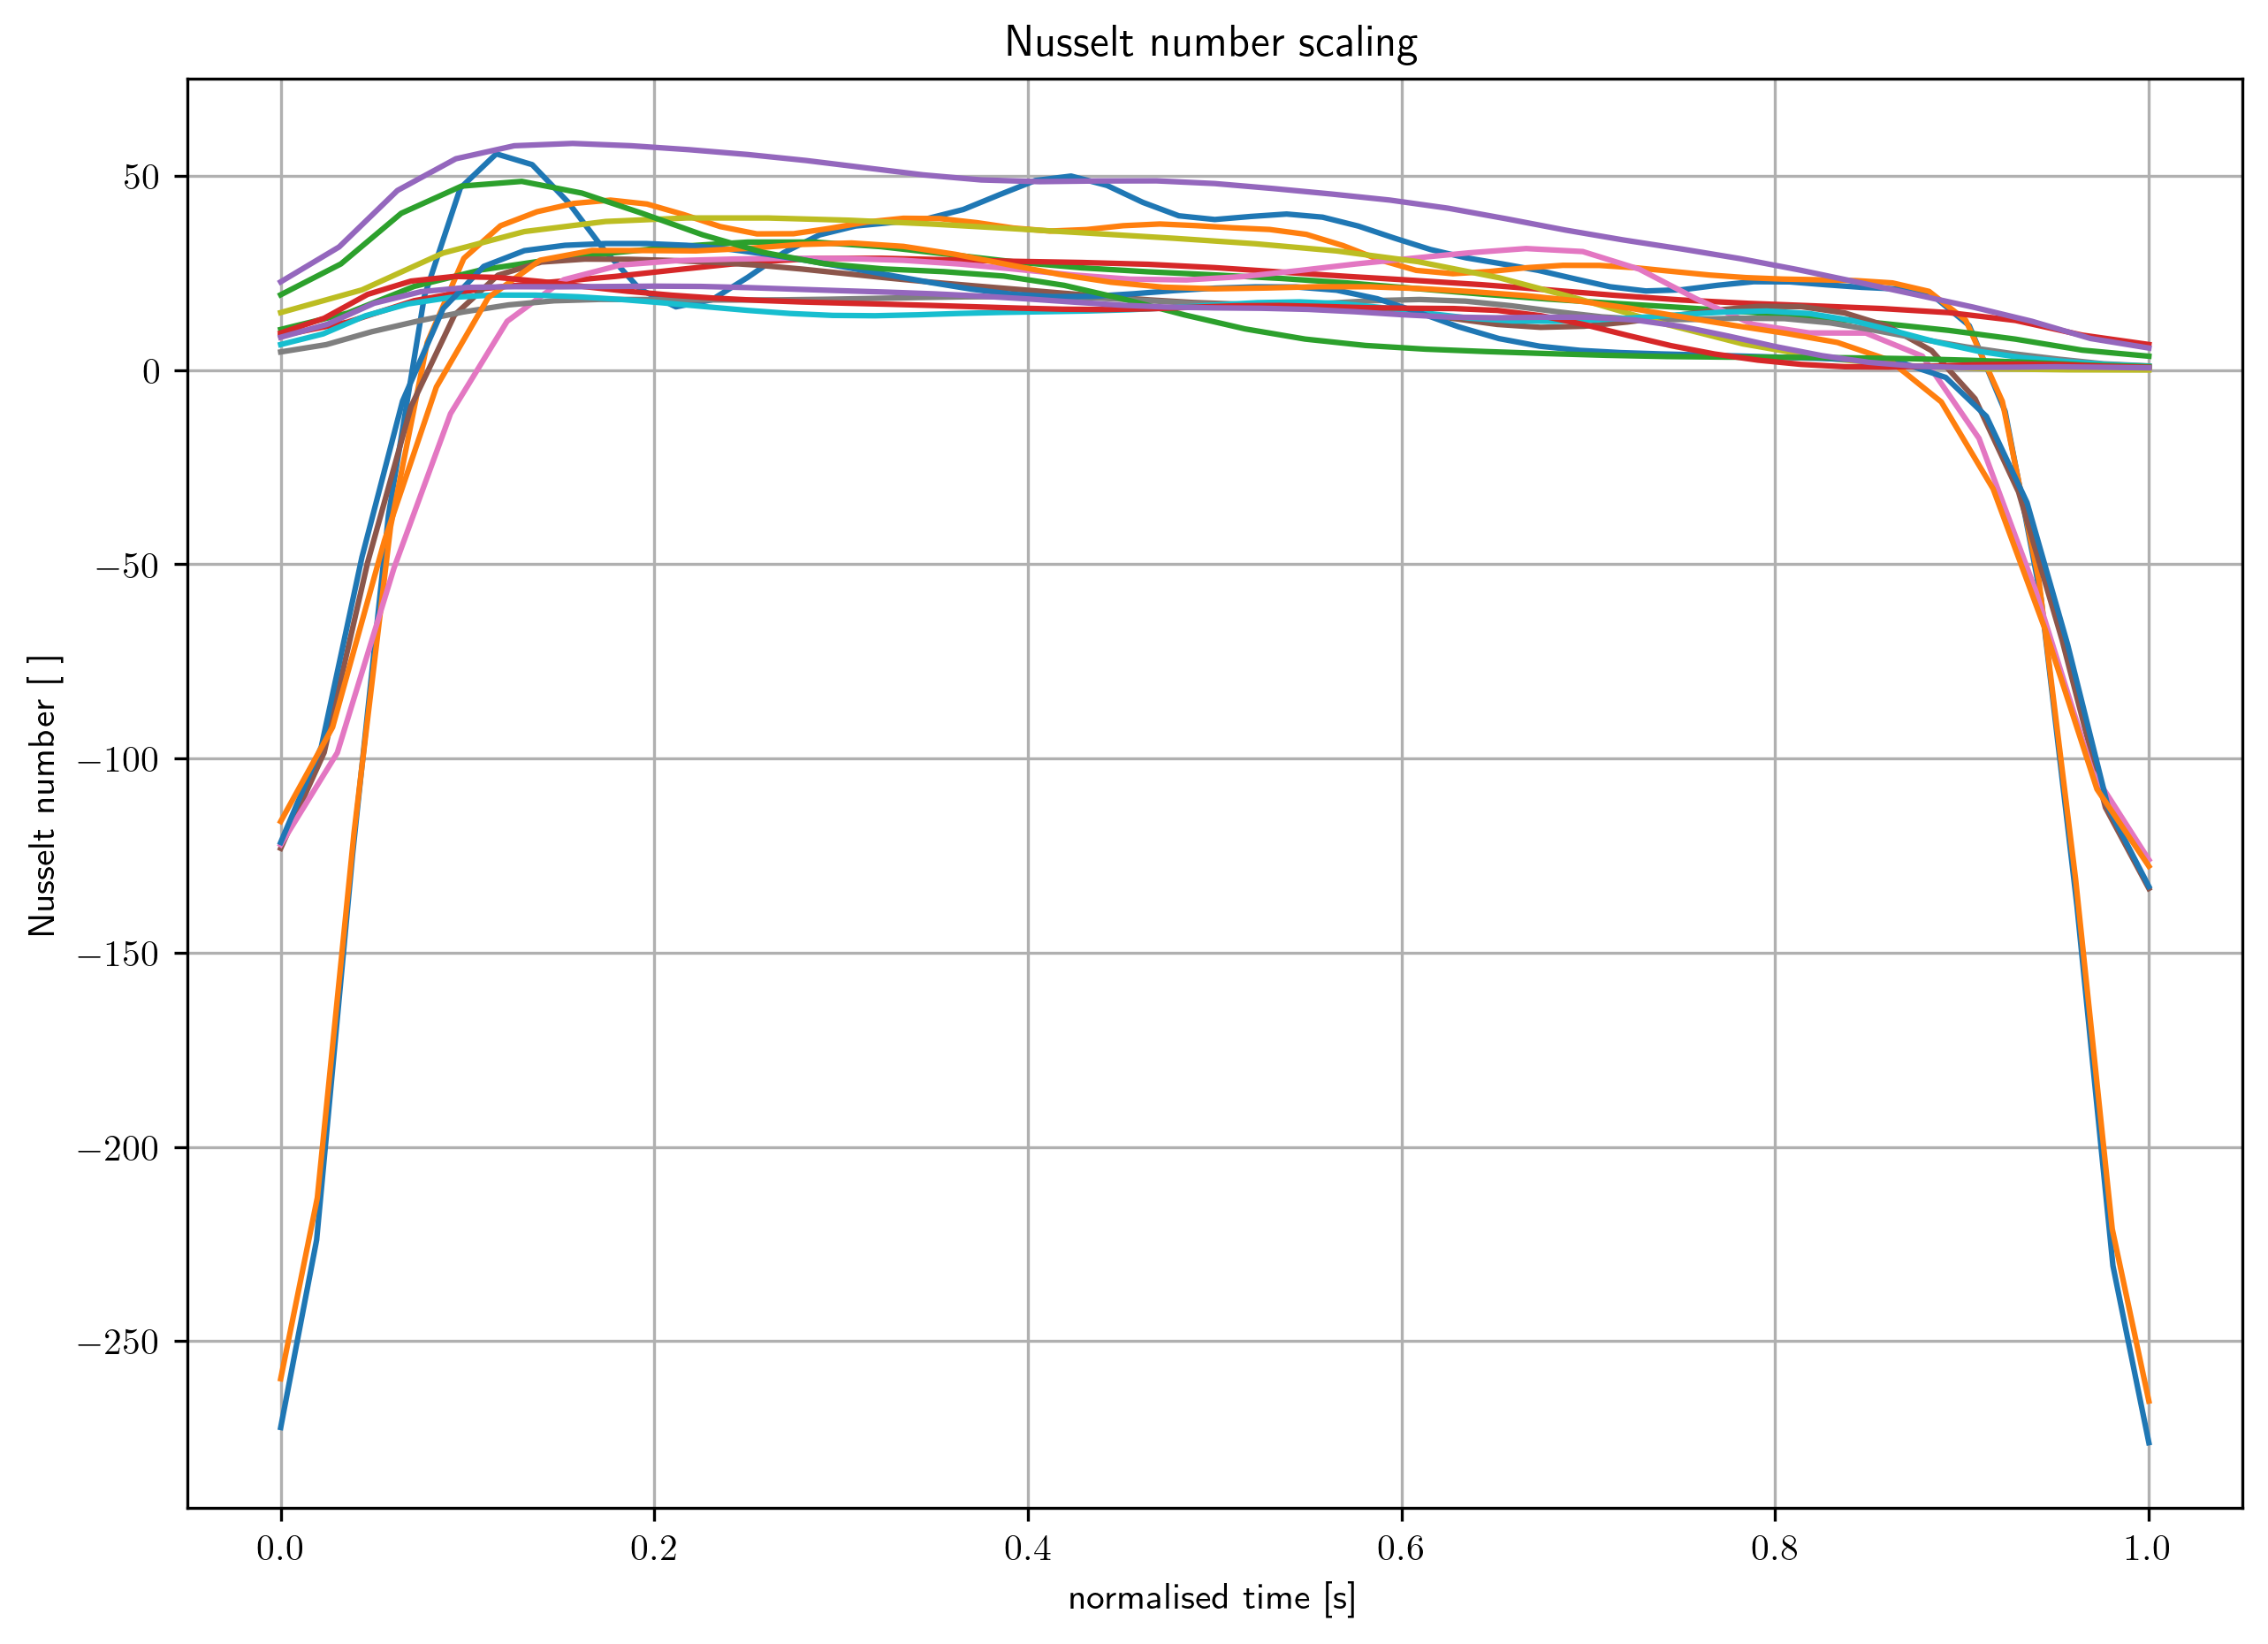

In [154]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st']# S=35

from scipy.ndimage import gaussian_filter1d as gf1d

plt.figure(figsize=(10,7),dpi=300)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    # print(contours_per_shot)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    #if exp_sal==35.: continue

    areas = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            initialArea = np.pi*exp_radius**2 # m2
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # px/m2
        # reduce the radius considering only the part that is below the upwelled freshwater (only for salty water)
        if exp_sal==0.:
            # if freshwater, consider all the polygon
            area = PolyArea(contour[:,1],contour[:,0]) #px
            areas.append(area)
        else:
            # find waterlevel
            wl = findWL(contour,densityRatio=917/MH_rho(exp_wt,S=exp_sal)) # px
            # find level of molten water
            moltenArea = initialArea - PolyArea(contour[:,1],contour[:,0])/conversion # in m2
            h = moltenArea/.8 # in m
            h = h*np.sqrt(conversion) # in px 
            # calculate polygon under the freshwater level
            contourInSaltyWater = makePolygonBelow(contour,-h+wl)
            # calculate equivalent radius
            area = PolyArea(contourInSaltyWater[:,1],contourInSaltyWater[:,0])
            areas.append(area)
    
    areas = correct_outliers(areas)

    areas = np.array(areas)
    areas /= conversion
    print(f'check area:......{exp_radius:.2e}',f'{np.sqrt(areas[0]/np.pi):.2e}')
    
    if exp_radius==0.0405:
        x = contours_per_shot*10*np.arange(len(areas))
        fit = np.poly1d(np.polyfit(x,areas,deg=4))
        areas_fit = fit(x)
        Nusselt_numbers = Nu_areas(gf1d(areas,2,mode='wrap'),exp_wt,10*contours_per_shot)
        plt.plot(np.linspace(0,1,len(Nusselt_numbers)),Nusselt_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.025:
        x = contours_per_shot*10*np.arange(len(areas))
        fit = np.poly1d(np.polyfit(x,areas,deg=4))
        areas_fit = fit(x)
        Nusselt_numbers = Nu_areas(gf1d(areas,2),exp_wt,10*contours_per_shot)
        plt.plot(np.linspace(0,1,len(Nusselt_numbers)),Nusselt_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.06:
        x = contours_per_shot*30*np.arange(len(areas))
        fit = np.poly1d(np.polyfit(x,areas,deg=4))
        areas_fit = fit(x)
        Nusselt_numbers = Nu_areas(gf1d(areas,2),exp_wt,30*contours_per_shot)
        plt.plot(np.linspace(0,1,len(Nusselt_numbers)),Nusselt_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds
    del x,fit

plt.grid()
# plt.legend()
plt.xlabel('normalised time [s]')
plt.ylabel('Nusselt number [ ]')
plt.title('Nusselt number scaling')

# plt.yscale('log')
# plt.ylim(1e4,1e10)

plt.show()

# Rayleigh vs Nusselt

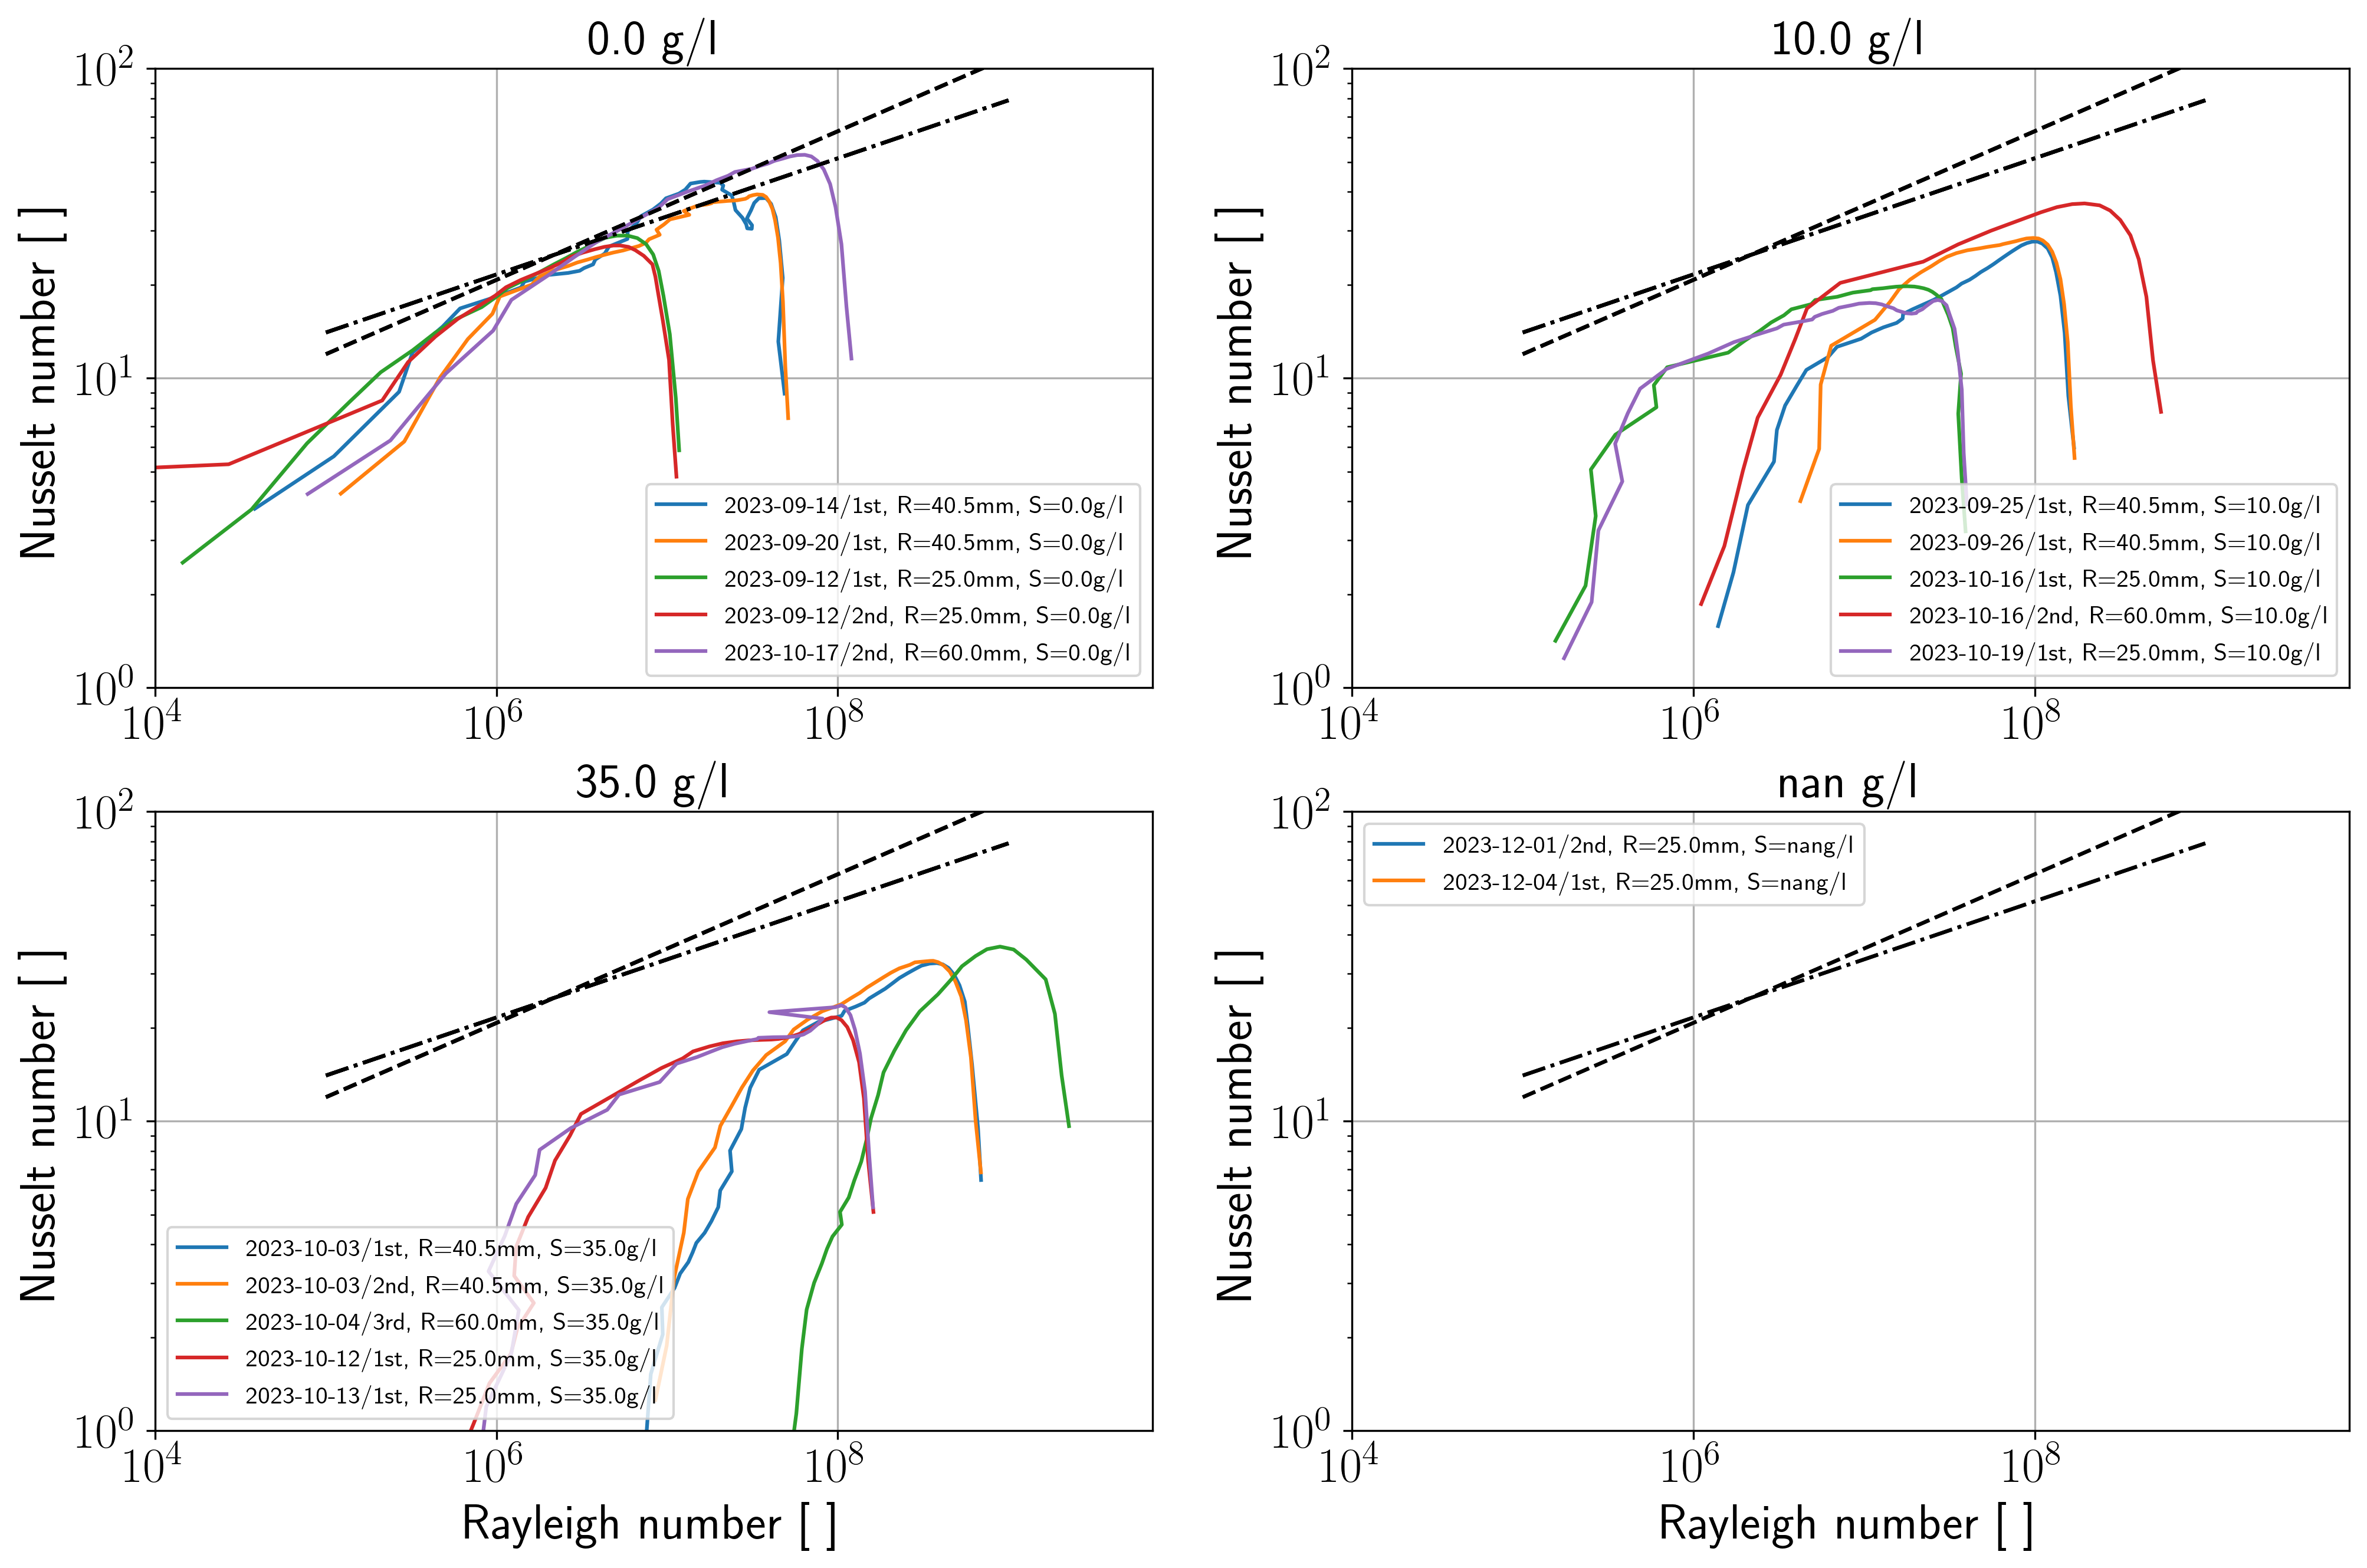

In [152]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,10),dpi=300)
plt.rcParams['text.usetex'] = True

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))

    radii = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            initialArea = np.pi*exp_radius**2 # px
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # px/m2
        # reduce the radius considering only the part that is below the upwelled freshwater (only for salty water)
        if exp_sal!=100.:
            # if freshwater, consider all the polygon
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            radii.append(radius)
        # else:
        #     # find waterlevel
        #     wl = findWL(contour,densityRatio=917/MH_rho(exp_wt,S=exp_sal)) # px
        #     # find level of molten water
        #     moltenArea = initialArea - PolyArea(contour[:,1],contour[:,0])/conversion # in m2
        #     h = moltenArea/.6 # in m
        #     h = h*np.sqrt(conversion) # in px 
        #     # calculate polygon under the freshwater level
        #     contourInSaltyWater = makePolygonBelow(contour,-h+wl)
        #     # calculate equivalent radius
        #     radius = np.sqrt(PolyArea(contourInSaltyWater[:,1],contourInSaltyWater[:,0])/np.pi)
        #     radii.append(radius)
    
    radii = correct_outliers(radii)

    conversion = info[1,1]/radii[0] # m/px
    radii = np.array(radii)
    radii *= conversion

    if exp_sal == 0.:
        axi = ax.flatten()[0]
    elif exp_sal == 10.:
        axi = ax.flatten()[1]
    elif exp_sal == 35.:
        axi = ax.flatten()[2]
    elif np.isnan(exp_sal):
        axi = ax.flatten()[3]

    if exp_radius==0.0405:
        Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
        
        areas = np.pi*radii**2
        Nusselt_numbers = Nu_areas(gf1d(areas,4),exp_wt,10*contours_per_shot)

        axi.plot(Rayleigh_numbers,Nusselt_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.025:
        Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
        
        areas = np.pi*radii**2
        Nusselt_numbers = Nu_areas(gf1d(areas,4),exp_wt,10*contours_per_shot)
        
        axi.plot(Rayleigh_numbers,Nusselt_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 10 seconds
    elif exp_radius==0.06:
        Rayleigh_numbers = Ra_salinity(radii,0,exp_wt,S=exp_sal)
        
        areas = np.pi*radii**2
        Nusselt_numbers = Nu_areas(gf1d(areas,4),exp_wt,30*contours_per_shot)
        
        axi.plot(Rayleigh_numbers,Nusselt_numbers,
                 label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds
    
    axi.set_title(f'{exp_sal} g/l',fontsize=20)
    axi.plot(np.logspace(5,9,50),25*np.logspace(-1,2,50)**.32,linestyle='--',c='k')
    axi.plot(np.logspace(5,9,50),25*np.logspace(-1,2,50)**.25,linestyle='-.',c='k')

for axi in ax.flatten():

    axi.grid()
    axi.legend()
    axi.set_ylabel('Nusselt number [ ]',fontsize=20)
    axi.set_xlabel('Rayleigh number [ ]',fontsize=20)
    if axi == ax.flatten()[0] or axi == ax.flatten()[1]:
        axi.set_xlabel('')

    axi.set_yscale('log')
    axi.set_xlim(1e4,7e9)
    axi.set_xscale('log')
    axi.set_ylim(1e0,1e2)

    axi.tick_params(axis='x', labelsize=20)
    axi.tick_params(axis='y', labelsize=20)

plt.show()

# Plot all contours

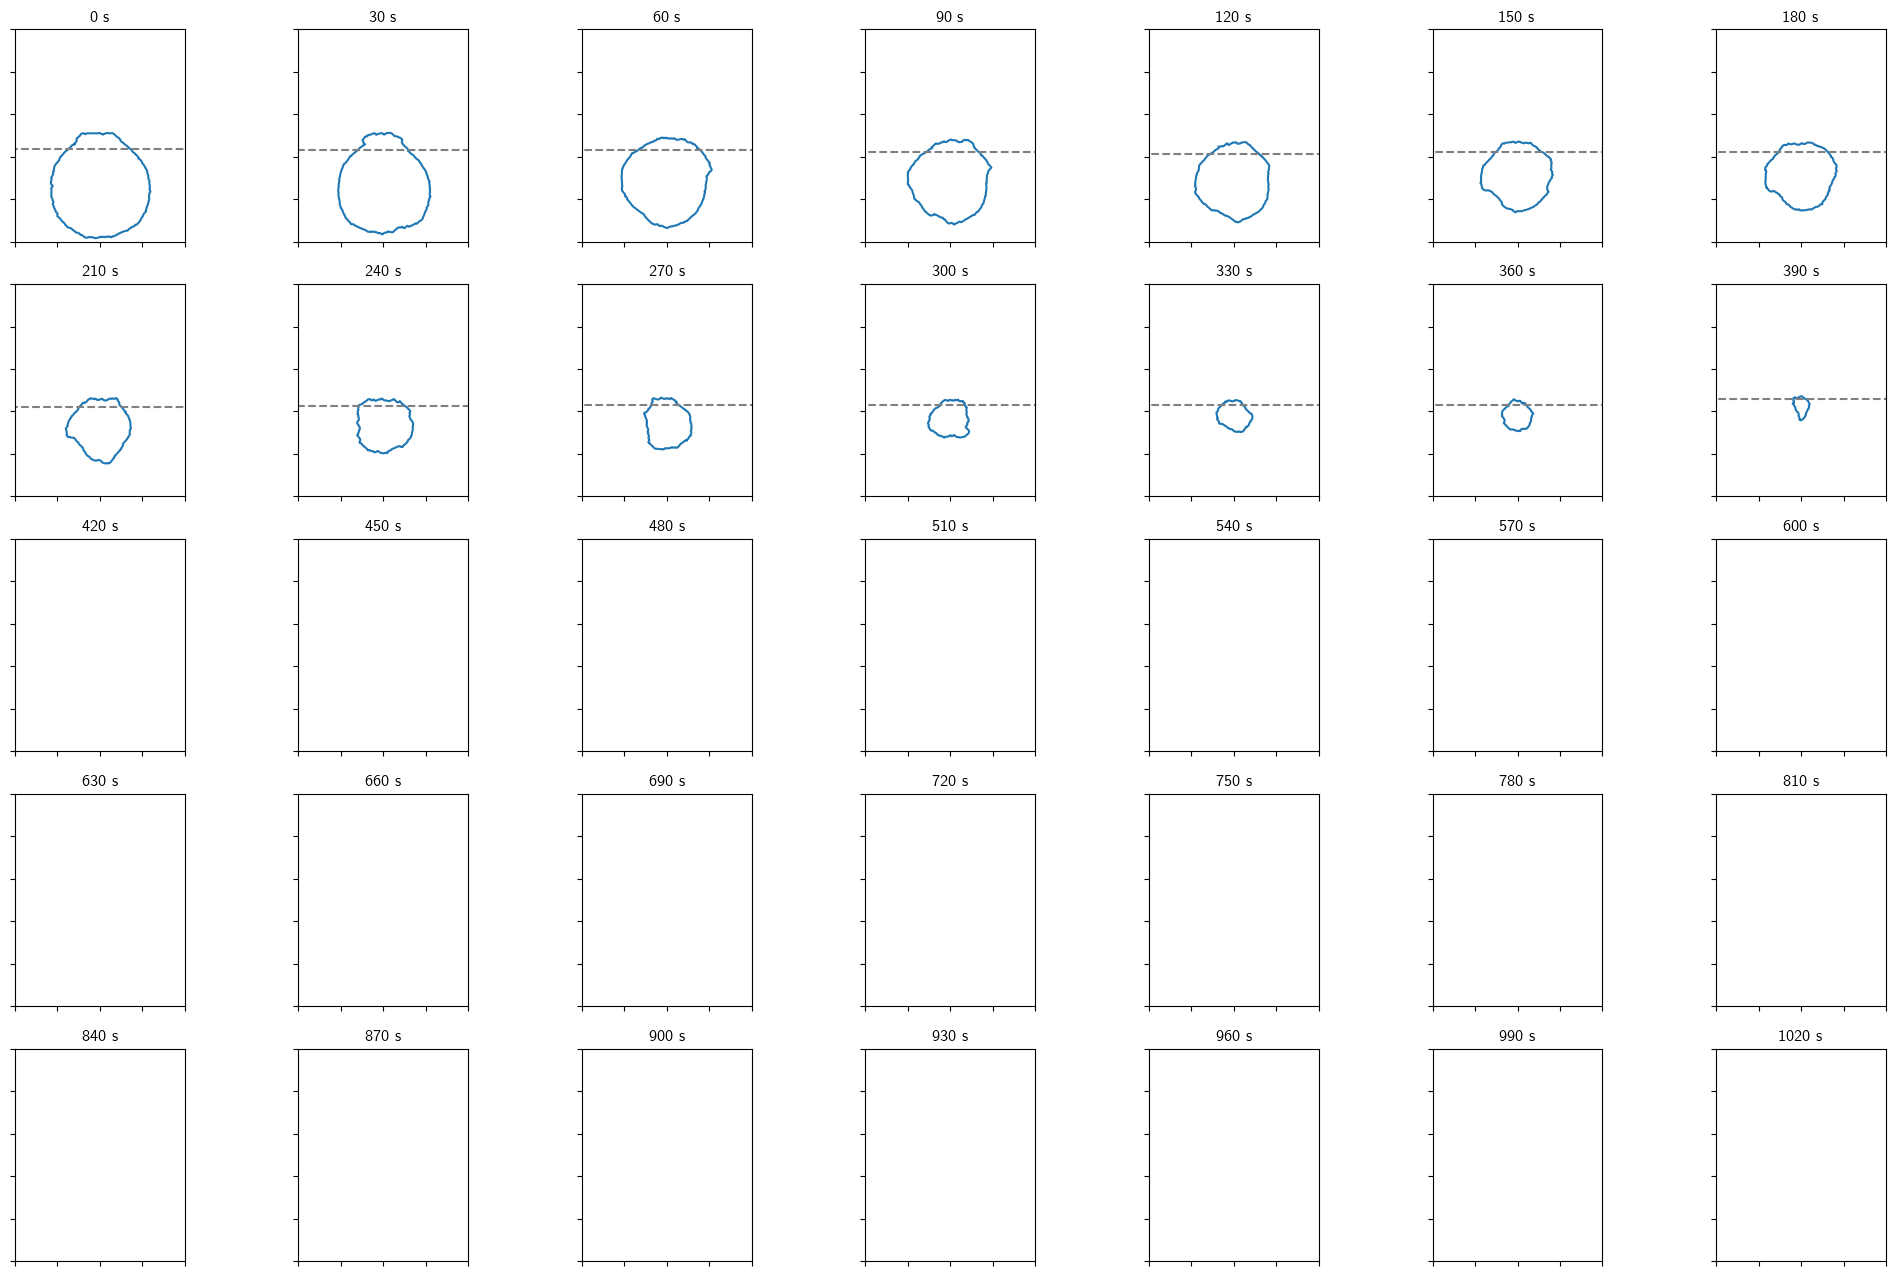

In [70]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-04/'
cylinders = ['1st']

fig, ax = plt.subplots(nrows=5,ncols=7,figsize=(25,16))

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
        contour[:,1 ] = -contour[:,1] + shift 
        xcenter = np.mean(contour,axis=0)[0]
        
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1])

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].hlines(wl,-1000,1000,linestyles='--',colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set_aspect('equal')
    axi.set_xticklabels('')
    axi.set_yticklabels('')
    axi.set_title(f'{it*30} s')
    axi.set_ylim(0,500)
    axi.set_xlim(-200,200)

plt.show()

In [89]:
min(contour[:,1])

3188.05

# Find waterline

### Test on one contour

NameError: name 'PolyArea' is not defined

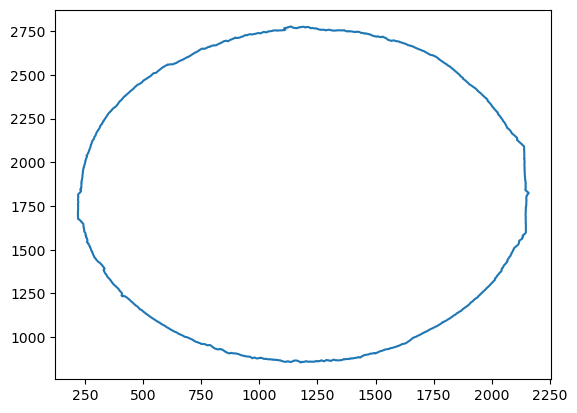

In [7]:
plt.figure()
contour = np.genfromtxt(contoursPATH[1],dtype='float',delimiter=',').T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

plt.plot(contour[:,0],contour[:,1],label='orig')



immersedPG = makePolygonBelow(contour,findWL(contour))
plt.plot(immersedPG[:,0],immersedPG[:,1],label='immersed')


plt.legend()
plt.gca().set_aspect('equal')
plt.show()

### Apply to all contours

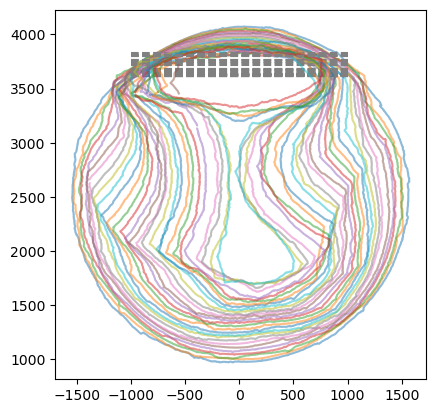

In [106]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-26/'
cylinders = ['1st']

plt.figure()

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
        contour[:,1 ] = -contour[:,1] + shift
        # plt.plot(contour[:,0],contour[:,1])
        xcenter = np.mean(contour,axis=0)[0]
        # plt.scatter(np.mean(contour,axis=0)[0],np.mean(contour,axis=0)[1])
        plt.plot(contour[:,0]-xcenter,contour[:,1],alpha=.5)

        wl = findWL(contour)
        plt.hlines(wl,-1000,1000,linestyles='--',colors='grey')


plt.gca().set_aspect('equal')

plt.show()

# Find stability

### Test on one contour

x-location difference CoM-CoB = -2.71 px


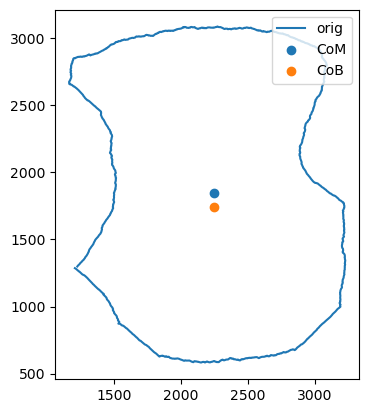

In [107]:
plt.figure()
contour = np.genfromtxt(contoursPATH[15],dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

plt.plot(contour[:,0],contour[:,1],label='orig')



com,cob = hydrostasy(contour)

plt.scatter(com.x,com.y,label='CoM')
plt.scatter(cob.x,cob.y,label='CoB')
print(f'x-location difference CoM-CoB = {com.x-cob.x:.2f} px')

plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
plt.show()

### Check rotations of contour

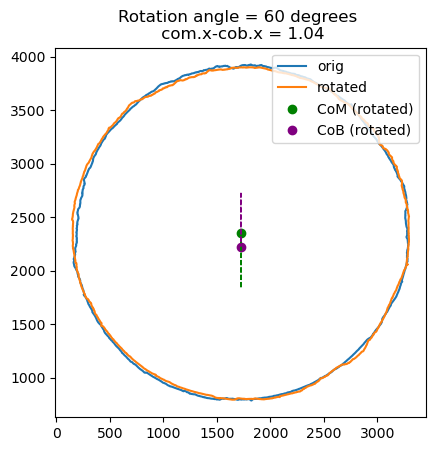

SUM Stability index = 142.5 degrees
DIFF Stability index = 8.0 degrees
NEW Stability index = 27.633865067300576


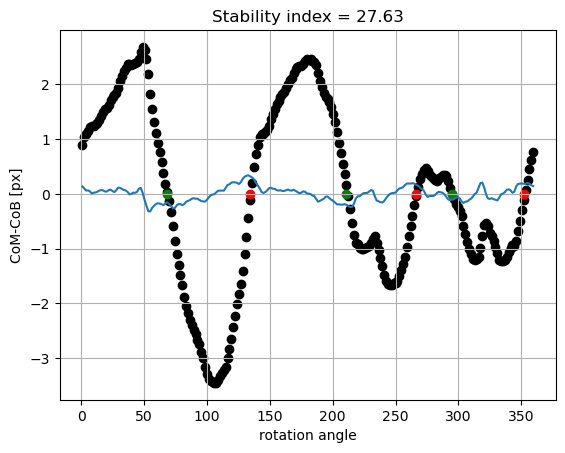

In [85]:
plt.figure()
contour = np.genfromtxt(contoursPATH[0],dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

rotAngle = 60
com,_ = hydrostasy(contour,densityRatio=917/1005)
rotatedCont = rotate(contour,[com.x,com.y],rotAngle)
plt.plot(contour[:,0],contour[:,1],label='orig')
plt.plot(rotatedCont[:,0],rotatedCont[:,1],label='rotated')
del com

com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
plt.title(f'Rotation angle = {rotAngle} degrees \n com.x-cob.x = {com.x-cob.x:.2f}')
plt.scatter(com.x,com.y,label='CoM (rotated)',c='green')
plt.scatter(cob.x,cob.y,label='CoB (rotated)',c='purple')
plt.arrow(com.x,com.y,0,-500,color='green',linestyle='--',width=1)
plt.arrow(cob.x,cob.y,0,500,color='purple',linestyle='--',width=0.1)

plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
plt.show()

plt.figure()
angleStep = 1.5
stability = np.zeros((int(360/angleStep),2))

for i,angle in enumerate(np.arange(1,360,angleStep)):
    com,_ = hydrostasy(contour,densityRatio=917/1005)
    rotatedCont = rotate(contour,[com.x,com.y],angle)
    del com
    com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
    stability[i] = angle, com.x-cob.x

plt.scatter(stability[:,0],stability[:,1],c='k')
zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
index_zc = stability[zero_crossings,0]
# plt.scatter(index_zc,np.zeros_like(index_zc),c='red')
plt.plot(stability[:,0],np.gradient(stability[:,1]))
unstablePointsAngles = []
for i in zero_crossings:
    if np.gradient(stability[:,1])[i]<0:
        plt.scatter(stability[i,0],0,c='green')
    else:
        plt.scatter(stability[i,0],0,c='red')
        unstablePointsAngles.append(stability[i,0])

# SUM is how distant are the two closest unstable equilibria
print(f'SUM Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')
# DIFF is how distant is the closest unstable equilibrium 
print(f'DIFF Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])} degrees')
print(f'NEW Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))}')

plt.ylabel('CoM-CoB [px]')
plt.xlabel('rotation angle')
plt.grid()
plt.title(f'Stability index = {min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1])):.2f}')
plt.show()

### Apply to all contours

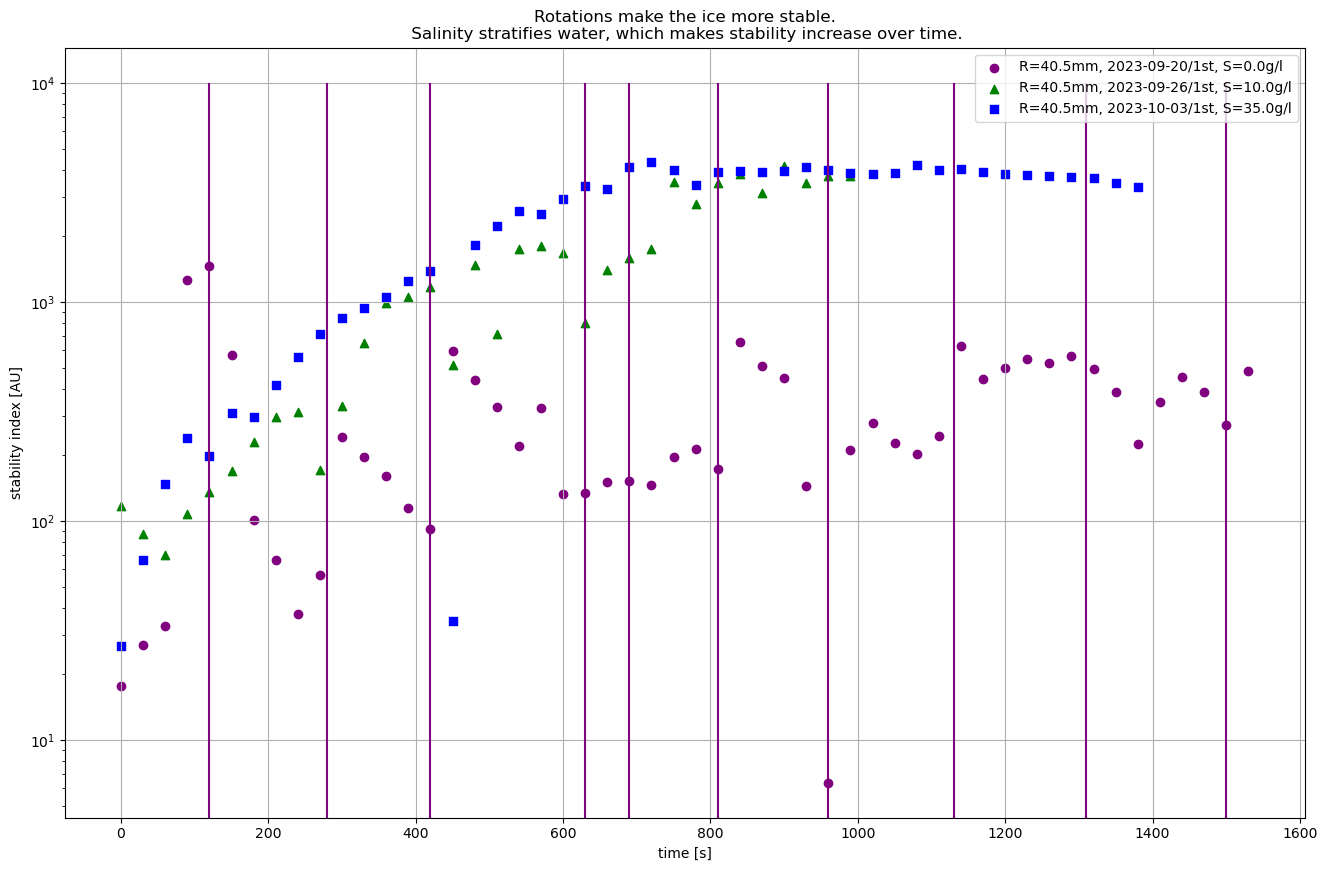

In [87]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-20/1st','2023-09-26/1st','2023-10-03/1st']

plt.figure(figsize=(16,10))

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
        contour[:,1 ] = -contour[:,1] + shift 
        
        angleStep = 1.5
        stability = np.zeros((int(360/angleStep),2))

        for i,angle in enumerate(np.arange(1,360,angleStep)):
            com,_ = hydrostasy(contour) ### CHANGE SALTY OR FRESH
            rotatedCont = rotate(contour,[com.x,com.y],angle)
            del com
            com,cob = hydrostasy(rotatedCont)  ### CHANGE SALTY OR FRESH
            stability[i] = angle, com.x-cob.x

        zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
        index_zc = stability[zero_crossings,0]
        unstablePointsAngles = []
        for i in zero_crossings:
            if np.gradient(stability[:,1])[i]>0:
                unstablePointsAngles.append(stability[i,0])

        # print(f'Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')
        kwargs_ = [['o','purple'],
                  ['^','green'],
                  ['s','blue']]
        
        if it==0:
            plt.scatter(30*it,min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1])),marker=kwargs_[ic][0],
                        c=kwargs_[ic][1],label=f'R={info[1,1]*1e3:.1f}mm, {cylinder}, S={info[1,0]}g/l')
        else:
            plt.scatter(30*it,min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1])),marker=kwargs_[ic][0],
                        c=kwargs_[ic][1])
        
# draw rotation lines
for t in [12,28,42,63,69,81,96,113,131,150]: # rotation times of 09/20/1st
   plt.vlines(t*10,0,1e4,colors='purple')
#for t in []: # rotation times of 09/20/1st
#    plt.vlines(t*10,25,375,colors='blue')

plt.xlabel('time [s]')
plt.ylabel('stability index [AU]')
plt.grid()
plt.legend()
#plt.ylim(0,4000)
plt.yscale('log')
plt.title('Rotations make the ice more stable.\n Salinity stratifies water, which makes stability increase over time.')
plt.show()


# Temperature penetration

/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_54634/2717402685.py:4: RuntimeWarning: overflow encountered in exp
  frac = erf(x/2*np.sqrt(alpha*t))+np.exp(h*x/kappa+h**2*alpha*t/kappa**2)*(1-erf(x/(2*np.sqrt(alpha*t)+h*np.sqrt(alpha*t)/kappa)))
/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_54634/2717402685.py:4: RuntimeWarning: invalid value encountered in multiply
  frac = erf(x/2*np.sqrt(alpha*t))+np.exp(h*x/kappa+h**2*alpha*t/kappa**2)*(1-erf(x/(2*np.sqrt(alpha*t)+h*np.sqrt(alpha*t)/kappa)))


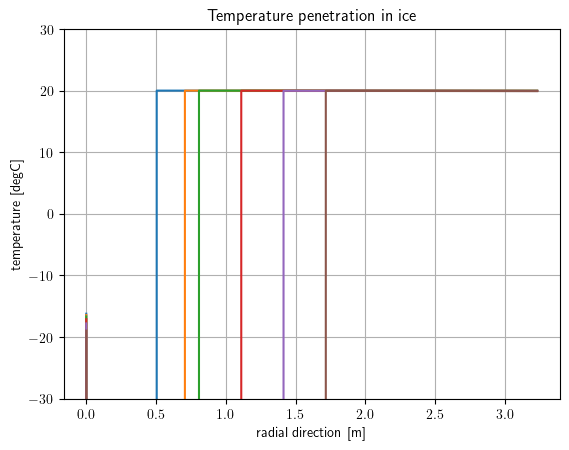

In [530]:
def Temp(x,t):
    T_i = -16 
    T_inf = 20
    frac = erf(x/2*np.sqrt(alpha*t))+np.exp(h*x/kappa+h**2*alpha*t/kappa**2)*(1-erf(x/(2*np.sqrt(alpha*t)+h*np.sqrt(alpha*t)/kappa)))
    return frac*(T_i-T_inf)+T_inf

plt.figure()

x = np.linspace(0,10,100)
for t in [1,2,3,5,8,13]:
    plt.plot(x,Temp(x,t))

plt.grid()
# plt.legend(loc='center left')
plt.xlabel('radial direction [m]')
plt.ylabel('temperature [degC]')
plt.title('Temperature penetration in ice')
plt.ylim(-30,30)
plt.show()

# Fresh water level L/R

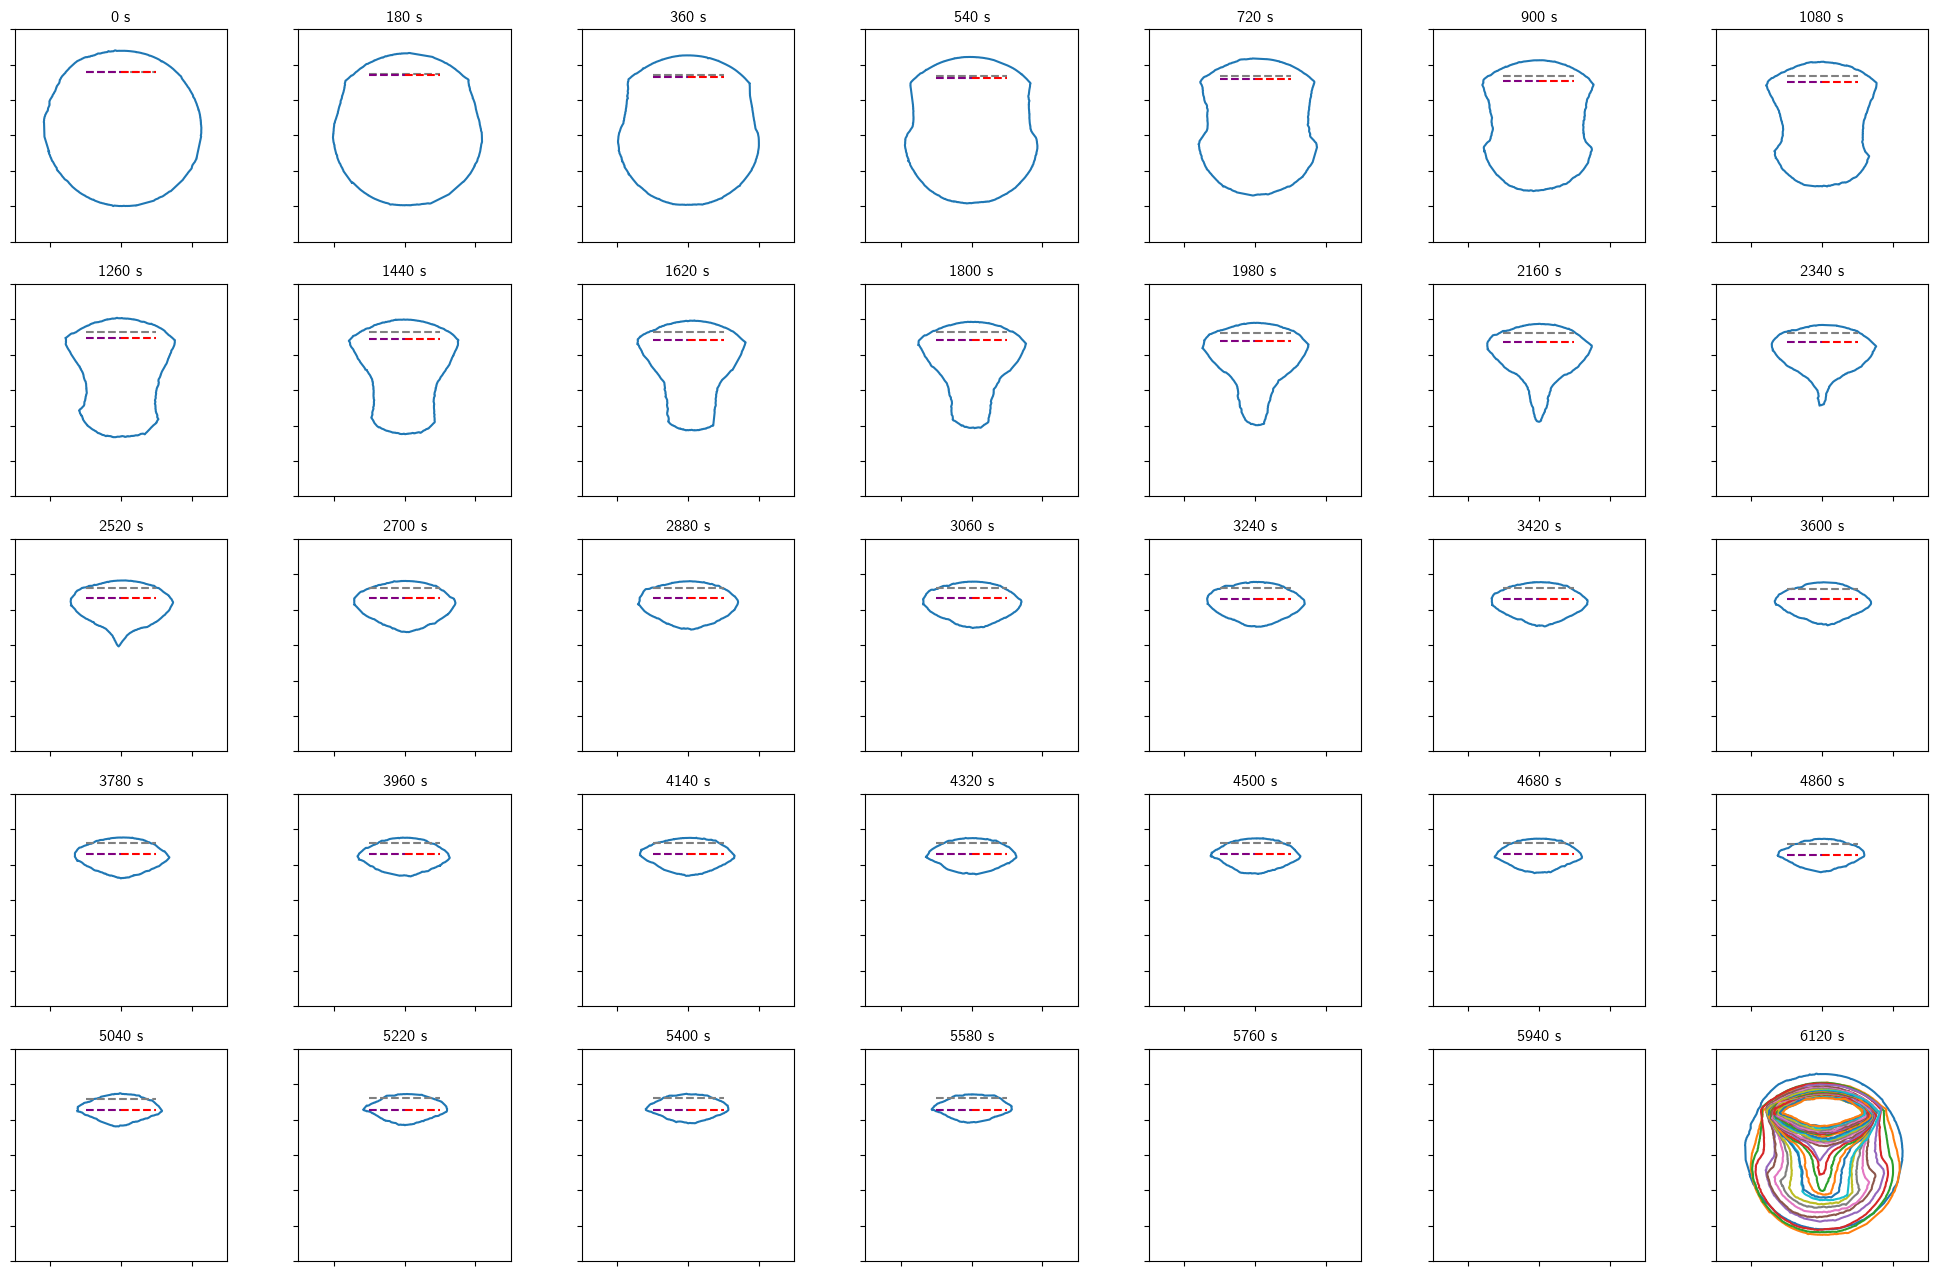

In [316]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-10-04/'
cylinders = ['3rd']

fig, ax = plt.subplots(nrows=5,ncols=7,figsize=(25,16))

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)


    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3 # straighten y direction
            initialArea = np.pi*.0405**2 # in m2
            conversion = PolyArea(contour[:,1],contour[:,0])/initialArea # in px/m2
        contour[:,1 ] = -contour[:,1] + shift 
        moltenArea = initialArea - PolyArea(contour[:,1],contour[:,0])/conversion # in m2
        # find freshwater layer depth supposing that the meltwater spreads according to the position in the tank
        #h1 = moltenArea/.27 # in m
        #h1 = h1*np.sqrt(conversion) # in px 
        #h2 = 27*h1/53
        # here instead suppose that it spreads evenly
        h1 = moltenArea/.8 # in m
        h1 = h1*np.sqrt(conversion) # in px 
        h2 = h1


        xcenter = np.mean(contour,axis=0)[0]
        
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1])
        ax.flatten()[-1].plot(contour[:,0]-xcenter,contour[:,1]-(wl-4500))

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].hlines(wl,-1000,1000,linestyles='--',colors='grey')
        ax.flatten()[it].hlines(-h1+wl,0,1000,linestyles='--',colors='red')
        ax.flatten()[it].hlines(-h2+wl,-1000,0,linestyles='--',colors='purple')

for it,axi in enumerate(ax.flatten()):
    axi.set_aspect('equal')
    axi.set_xticklabels('')
    axi.set_yticklabels('')
    axi.set_title(f'{it*180} s')
    axi.set_ylim(0,6000)
    axi.set_xlim(-3000,3000)

plt.show()

# Index of refraction problem

In [5]:
# see Cristopher Parrish 2020
def n_seaw(T=20):
    lambdaa = 550 # [nm], valid in 400-700
    a = -1.50156e-6
    b = 1.07085e-7
    c = -4.27594e-5
    d = -1.60476e-4
    e = 1.39807
    return a*T**2 + b*lambdaa**2 + c*T + d*lambdaa + e

def n_freshw(T=20):
    lambdaa = 550 # [nm], valid in 400-700
    a = -1.97812e-6
    b = 1.03223e-7
    c = -8.58125e-6
    d = -1.54834e-4
    e = 1.38919
    return a*T**2 + b*lambdaa**2 + c*T + d*lambdaa + e

print(n_seaw(),n_freshw())
print(np.rad2deg(np.arcsin(n_freshw()/n_seaw())))

1.3407456005 1.3342933845
84.37667467204439


# Make gif

In [19]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-10-03/'
cylinders = ['1st']

from PIL import Image
    
for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        plt.figure(figsize=(8,8))
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
        contour[:,1 ] = -contour[:,1] + shift 
        xcenter = np.mean(contour,axis=0)[0]
        
        plt.plot(contour[:,0]-xcenter,contour[:,1])

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        plt.hlines(wl,-1000,1000,linestyles='--',colors='grey')

        plt.gca().set_aspect('equal')
        plt.gca().set_xticklabels('')
        plt.gca().set_yticklabels('')
        #plt.gca().set_title(f'{it*30} s')
        plt.gca().set_ylim(500,4500)
        plt.gca().set_xlim(-2000,2000)

        plt.savefig(directory+cylinder+f'/gif/{it:02d}.png', format='png')
        plt.close()

def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(frame_folder+'melting.gif', format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)

make_gif(directory+cylinders[0]+'/gif/')


# Nu vs strength of downward flow

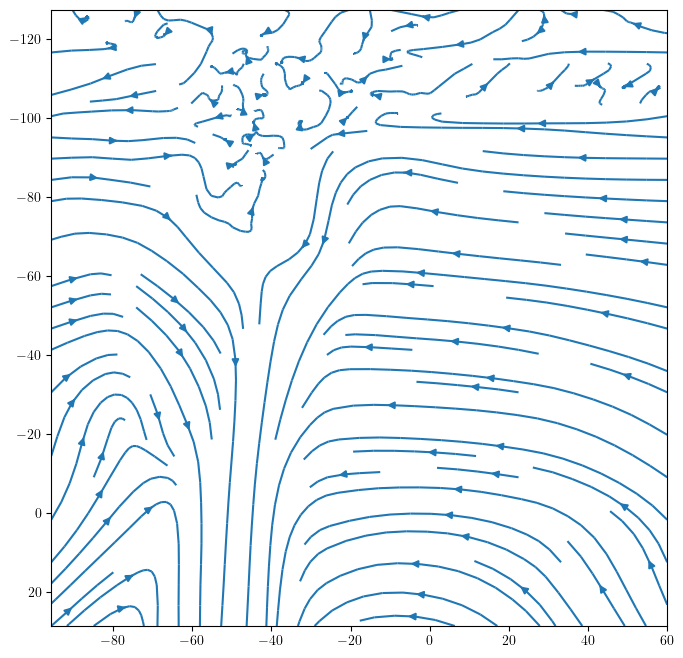

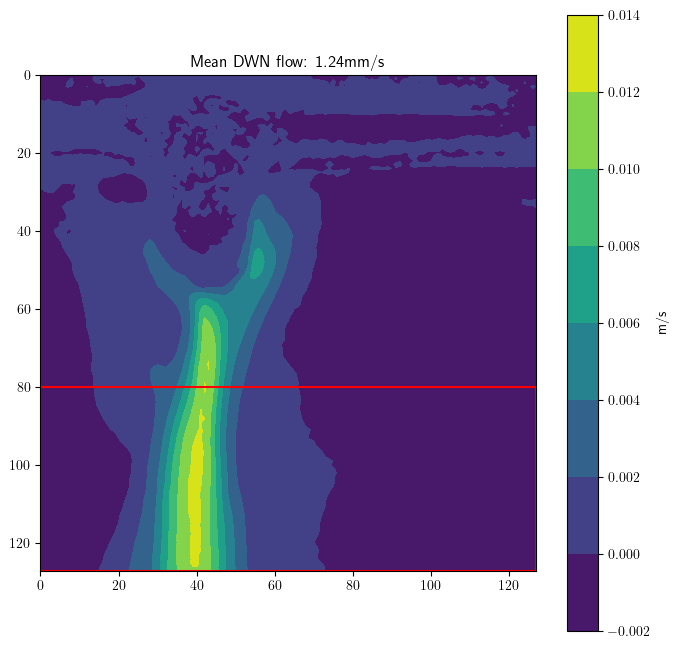

In [76]:
pivData = np.genfromtxt('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/S35_81mm_avgField.TXT').T
x,y,u,v = pivData
side = np.sqrt(x.shape[0]).astype(int)

# regularly spaced grid spanning the domain of x and y 
xi = np.linspace(x.min(), x.max(), side)
yi = np.linspace(y.min(), y.max(), side)
X,Y = np.meshgrid(xi,yi)


ui = np.reshape(u,(side,side))
vi = np.reshape(-v,(side,side))

plt.figure(figsize=(8,8))
plt.streamplot(X,Y,ui,vi)
plt.xlabel('')
plt.ylabel('')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/S35_81mm_randomShot_PIV.png',transparent=True)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8,8))
im = plt.contourf(vi)
plt.colorbar(im,label='m/s')
plt.plot([0,0,127,127,0],[127,80,80,127,127],c='r')
dwnFlow = np.mean(vi[80:,:])
plt.xlabel('')
plt.ylabel('')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/S35_81mm_randomShot_PIV.png',transparent=True)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.title(f'Mean DWN flow: {dwnFlow*1e3:.2f}mm/s')
plt.show()

[-1.65875426e-02  7.01820630e-01  4.10827730e+01  8.38216032e+00]


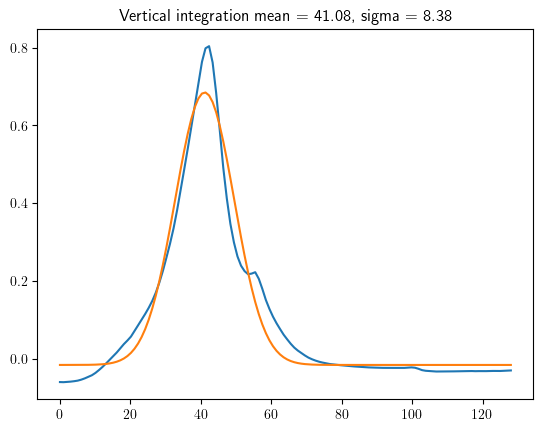

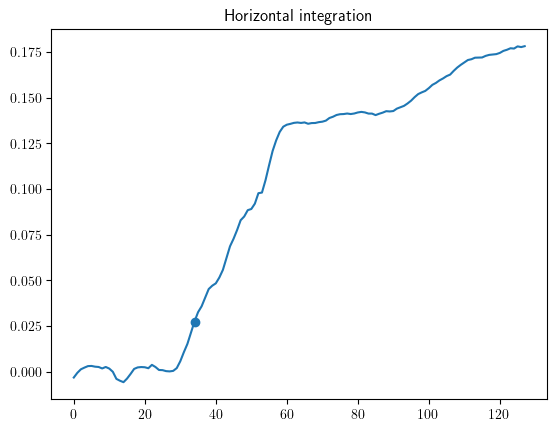

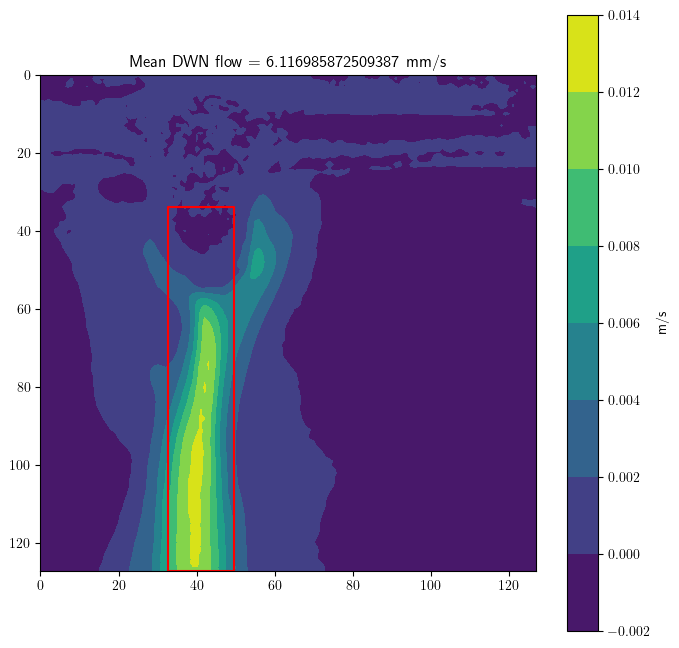

In [107]:
from scipy.optimize import curve_fit 

data = np.sum(vi[:,:],axis=0)
xdata = np.linspace(0,len(data),data.shape[0])

# Define the Gaussian function 
def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

parameters, _ = curve_fit(gauss, xdata, data,p0=[0.,0.6,40,10]) 
  
H,A,x0,sigma = parameters
print(parameters)

fit_y = gauss(xdata, H,A,x0,sigma) 

plt.figure()
plt.plot(xdata,data)
plt.plot(xdata,fit_y)
plt.title(f'Vertical integration mean = {x0:.2f}, sigma = {sigma:.2f}')
plt.show()

plt.figure()
dataHR = np.sum(vi[:,:],axis=1)
plt.plot(dataHR)
moreThanZero = np.where(dataHR>0.025)[0][0]
plt.scatter(ll,dataHR[ll])
plt.title(f'Horizontal integration ')
plt.show()


plt.figure(figsize=(8,8))
im = plt.contourf(vi)
plt.colorbar(im,label='m/s')
plt.plot([x0-sigma,x0-sigma,x0+sigma,x0+sigma,x0-sigma],[127,moreThanZero,moreThanZero,127,127],c='r')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.title(f'Mean DWN flow = {np.mean(vi[moreThanZero:,int(x0-sigma):int(x0+sigma)])*1000} mm/s')
plt.show()